<h1><center>SOME/IP protocol Anomaly Detection using Deep Learning</center></h1>

This    work   presents    an    anomaly    detection  based on Deep Learning  for SOME/IP,   a   standardized   automotive   middleware   protocol. We will use Sequential models to detect intrusions in a sequence of SOME/IP packets. Finally,  the  performance  of  the  system  is  evaluated.

# Import essential Libraries

In [1]:
# Scapy is a powerful interactive packet manipulation program. 
#It is able to forge or decode packets of a wide number of protocols, send them on the wire, capture them, match requests and replies, 
#and much more.
import scapy
from scapy.all import *

# Load the contribution of someip
load_contrib("automotive.someip")



# Pandas library for data manipulation and analysis.
import pandas as pd 

# Keras, a Python interface for artificial neural networks.
import tensorflow as tf 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# The xml.etree.ElementTree module implements a simple and efficient API for parsing and creating XML data.
import xml.etree.ElementTree as ET
import io

#NumPy is a Python library used for working with arrays.
import numpy as np

# Matplotlib is a comprehensive library for creating static, animated, and interactive visualizations in Python.
import matplotlib.pyplot as plt

import seaborn as sns 

# Split arrays or matrices into random train and test subsets
from sklearn.model_selection import train_test_split

# Functions for Pre-processing Dataframes 

The function "constructpacketframe" converts a pcap file to a dataframe. The pcap file contains information about 
a packet trace. This function returns a dataframe of 17 features(column names) : timestamp of each packet, its service id, its message type, its client id, its session id, its interface version, its method id, its length, its 
protocol version, its return code, its ip source , its ip destination, its protocol, its source port, its destination port, its mac source, its mac destination. 

In [2]:
def constructpacketframe(file):
        timestamp=[]
        srv_id=[]
        method_id=[]
        length=[]
        client_id=[]
        session_id=[]
        proto_ver=[]
        iface_ver=[]
        msg_type=[]
        retcode=[]
        
        ip_src=[]
        ip_dst=[]
        proto=[]
        
        sport=[]
        dport=[]
        
        mac_src=[]
        mac_dst=[]
        
        
        data={}

        
        pkts = rdpcap(file)


        l=[] 
        for i in range(0,len(pkts)):
                if(i==0):
                    timestamp.append(0)
                else:
                    timestamp.append(pkts[i].time - pkts[0].time)
                
                srv_id.append(pkts[i][SOMEIP].srv_id)
                msg_type.append(pkts[i][SOMEIP].msg_type)
                client_id.append(pkts[i][SOMEIP].client_id)
                session_id.append(pkts[i][SOMEIP].session_id)
                iface_ver.append(pkts[i][SOMEIP].iface_ver)
                method_id.append(pkts[i][SOMEIP].method_id)
                length.append(pkts[i][SOMEIP].len)
                proto_ver.append(pkts[i][SOMEIP].proto_ver)
                retcode.append(pkts[i][SOMEIP].retcode)
                
                ip_src.append(pkts[i][IP].src)
                ip_dst.append(pkts[i][IP].dst)
                proto.append(pkts[i][IP].proto)
                
                
                sport.append(pkts[i][UDP].sport)
                dport.append(pkts[i][UDP].dport)
                
                mac_src.append(pkts[i][Ether].src)
                mac_dst.append(pkts[i][Ether].dst)
                
                
                
                
                data["timestamp"]=timestamp
                data["srv_id"]=srv_id
                data["msg_type"]=msg_type
                data["client_id"]=client_id
                data["session_id"]=session_id
                data["iface_ver"]=iface_ver
                data["method_id"]=method_id
                data["length"]=length
                data["proto_ver"]=proto_ver
                data["retcode"]=retcode
                
                data["ip_src"]=ip_src
                data["ip_dst"]=ip_dst
                data["proto"]=proto
                
                data["sport"]=sport
                data["dport"]=dport
                
                data["mac_src"]=mac_src
                data["mac_dst"]=mac_dst
                
                
                



                df=pd.DataFrame(data,columns=["timestamp","srv_id","msg_type","client_id","session_id","iface_ver","method_id","length","proto_ver","retcode","ip_src","ip_dst","proto","sport","dport","mac_src","mac_dst"])
        return df

The function "construct_services" constructs a dataframe out of an xml format which states the configuration of the SOME/IP services in a network communication. 

In [3]:
def construct_services(file): 
    tree = ET.parse(file)
    root = tree.getroot()
    
    method_dict={}
    service_id=[]
    method_id=[]
    Type=[]
    client_id=[]
    timesensitive=[]
    client_min=[]
    client_max=[]
    client_resendMin=[]
    client_resendMax=[]
    server_id=[]
    errorRate=[]
    server_min=[]
    server_max=[]
    data={}
    all_dict=[]
    
    for service in root.iter("service"):
        method_dict.update(service.attrib)
        for method in service.iter("method"):
            method_dict.update(method.attrib)
            for client in method.iter('client'):
                method_dict.update(client.attrib)
                for servers in service.iter("servers"):
                    for server in servers.iter("server"):
                        method_dict.update(server.attrib)
                        #print(method_dict)

                        service_id.append(int(method_dict["service_id"], 16))
                        method_id.append(int(method_dict["method_id"], 16))
                        Type.append(method_dict["type"])
                        client_id.append(method_dict["client_id"])
                        timesensitive.append(method_dict["timesensitive"])
                        client_min.append(method_dict["client_min"])
                        client_max.append(method_dict["client_max"])
                        client_resendMin.append(method_dict["client_resendMin"])
                        client_resendMax.append(method_dict["client_resendMax"])
                        server_id.append(method_dict["server_id"])
                        errorRate.append(method_dict["errorRate"])
                        server_min.append(method_dict["server_min"])
                        server_max.append(method_dict["server_max"])

                        data["service_id"]=service_id
                        data["method_id"]=method_id
                        data["Type"]=Type
                        data["client_id"]=client_id
                        data["timesensitive"]=timesensitive
                        data["client_min"]=client_min
                        data["client_max"]=client_max
                        data["client_resendMin"]=client_resendMin
                        data["client_resendMax"]=client_resendMax
                        data["server_id"]=server_id
                        data["errorRate"]=errorRate
                        data["server_min"]=server_min
                        data["server_max"]=server_max



    services=pd.DataFrame(data,columns=["service_id","method_id","Type","client_id","timesensitive","client_min","client_max","client_resendMin","client_resendMax","server_id","errorRate","server_min","server_max"])
    
    return services

The function "construct_devices" constructs a dataframe out of an xml format which states the configuration of the devices participating in a network communication. These devices are : clients, servers, and attackers

In [4]:
def construct_devices(file):
    tree1 = ET.parse(file)
    root = tree1.getroot()


    return_data=[]
    device_dict={}
    name=[]
    device_type=[]
    mac=[]
    ip=[]
    sendPort=[]
    clientid=[]
    recPort=[]

    devices_data={}


    for device in root.iter("device"):
        #li.append(device_dict)
        device_dict.update(device.attrib)
        #print(device_dict)
        name.append(device_dict["name"])
        device_type.append(device_dict["type"])
        if(device_dict["type"]!="server"):
            clientid.append(device_dict["clientID"])
        else:
            clientid.append(0)


        mac.append(device_dict["mac"])
        ip.append(device_dict["ip"])
        sendPort.append(device_dict["sendPort"])
        recPort.append(device_dict["recPort"])


        devices_data["name"]=name
        devices_data["clientid"]=clientid
        devices_data["device_type"]=device_type
        devices_data["mac"]=mac
        devices_data["ip"]=ip
        devices_data["sendPort"]=sendPort
        devices_data["recPort"]=recPort




    devices=pd.DataFrame(devices_data,columns=["name","clientid","device_type","mac","ip","sendPort","recPort"])
    
    return_data.append(devices)
    
    clients=devices[devices["device_type"]=="client"].reset_index(drop=True)
    
    return_data.append(clients)
    
    servers=devices[devices["device_type"]=="server"].reset_index(drop=True)
    
    return_data.append(servers)
    
    attacker=devices[devices["device_type"]=="attacker"].reset_index(drop=True)
    
    return_data.append(attacker)
    
    # get devices : construct_devices("devices.xml")[0]
    # get clients : construct_devices("devices.xml")[1]
    # get servers : construct_devices("devices.xml")[2]
    # get attacker : construct_devices("devices.xml")[3]

    return return_data                   

The function "construct_devices" constructs a configuration dataframe by merging three dataframes constructed by the aforementionned functions. The merged dataframes are services, clients and servers. The configuration lists information for each service between each corresponding client and server. 

In [5]:
def create_configuration(services,clients,servers):

    s1=pd.merge(services,clients,right_on="name",left_on="client_id")
    s2=pd.merge(s1,servers,right_on="name",left_on="server_id")
    s2["Client_id"]=s2["clientid_x"]
    s2["client_mac"]=s2["mac_x"]
    s2["client_ip"]=s2["ip_x"]
    s2["client_send_port"]=s2["sendPort_x"]
    s2["client_rec_port"]=s2["recPort_x"]
    s2["server_mac"]=s2["mac_y"]
    s2["server_ip"]=s2["ip_y"]
    s2["server_send_port"]=s2["sendPort_y"]
    s2["server_rec_port"]=s2["recPort_y"]


    s2.drop(columns=["server_id","client_id","name_x","device_type_x","name_y","clientid_y","device_type_y","clientid_x","mac_x","ip_x","sendPort_x","recPort_x","mac_y","ip_y","sendPort_y","recPort_y"],inplace=True)
    
        
    s2["Client_id"]=s2["Client_id"].astype(int)
    s2["client_id"]=s2["Client_id"]
    
    
    s2.to_csv("config.csv")
    
    return s2

The function "packet_transform" takes as parameters a configuration file(depicted as s2) and a pcap file and merges 
them. The reason behind creating this dataframe is to show for each packet its already pre-defined service,client and server information because some attacks on the pcap file will change them.

In [6]:
def packets_transform(file,configuration):
    df=constructpacketframe(file)
    df["service_id"]=df["srv_id"]
    df.drop(columns=["srv_id"],inplace=True)
    df["ip_server"]=df['ip_src'].apply(lambda x: x if x[0:7] == '10.0.0.' else '10')
    df["ip_server"]
    df.loc[df['ip_server'] == "10" , 'ip_server'] = df["ip_dst"] 
    df['ip_server']
    df.rename(columns={'method_id':'Method_id'}, inplace = True)
    df.rename(columns={'client_id':'Client_id'}, inplace = True)
    df.rename(columns={'service_id':'Service_id'}, inplace = True)
    s3=pd.merge(df,configuration,left_on = ['Service_id','Method_id','Client_id','ip_server'],right_on = ['service_id','method_id','client_id','server_ip'])
    s3.drop(columns=["Service_id","Method_id","client_id","ip_server","Client_id_x"],inplace=True)
    s3.rename(columns={'Client_id_y':'Client_id'}, inplace = True)
    s3["label"]="label"
    return s3
    

# Functions for Labeling Dataframes with attacks

In [7]:
# Note : there is another erroronerror function that I have written and might test it 

I chose the first one

In [8]:
def erroronerror(df):
    for i in range(len(df)):
        first = df.iloc[i]
        if (first.msg_type==129):
                if(i<100):
                    packets_find=df.iloc[0:i,:]
                else:
                    packets_find=df.iloc[i-100:i,:]

                d=packets_find[(packets_find["msg_type"]!=129) & (packets_find["msg_type"]!=128) & (packets_find["service_id"]==first.service_id) & (packets_find["method_id"]==first.method_id) & (packets_find["Client_id"]==first.Client_id) & (packets_find["session_id"]==first.session_id) &
                        (packets_find["ip_dst"]==first.ip_src) & (packets_find["ip_src"]==first.ip_dst) & (packets_find["mac_src"]==first.mac_dst) & (packets_find["mac_dst"]==first.mac_src) & (packets_find["sport"]==first.dport)
                          & (packets_find["timestamp"] < first.timestamp) & (packets_find["timestamp"] < first.timestamp + first.server_max)]
                if (len(d)==0):
                    df["label"][i]="ErrorOnError"
                    #return "ErrorOnError"
                else:
                    df["label"][i]="Normal"
                    #return "Normal"
        else :
            df["label"][i]="Normal"
            #return "Normal"
        
    

In [9]:
def erroronerror(df):
    for i in range(len(df)):
        first = df.iloc[i]
        if (first.msg_type==128):
                if(i<100):
                    packets_find=df.iloc[0:i,:]
                else:
                    packets_find=df.iloc[i-100:i,:]

                d=packets_find[(packets_find["msg_type"]==0) & (packets_find["msg_type"]!=128) & (packets_find["service_id"]==first.service_id) & (packets_find["method_id"]==first.method_id) & (packets_find["Client_id"]==first.Client_id) & (packets_find["session_id"]==first.session_id) &
                        (packets_find["ip_dst"]==first.ip_src) & (packets_find["ip_src"]==first.ip_dst) & (packets_find["mac_src"]==first.mac_dst) & (packets_find["mac_dst"]==first.mac_src) & (packets_find["sport"]==first.dport)
                          & (packets_find["timestamp"] < first.timestamp) & (packets_find["timestamp"] < first.timestamp + first.server_max)]
                if (len(d)==0):
                    df["label"][i]="ErrorOnError"
                    #return "ErrorOnError"
                else:
                    df["label"][i]="Normal"
                    #return "Normal"
        else :
            df["label"][i]="Normal"
            #return "Normal"
        
    

In [10]:
def erroronevent(df):
    for i in range(len(df)):
        first = df.iloc[i]
        if (first.msg_type==129):
                if(i<100):
                    packets_find=df.iloc[0:i,:]
                else:
                    packets_find=df.iloc[i-100:i,:]

                d=packets_find[((packets_find["msg_type"]==1) | (packets_find["msg_type"]==2))& (packets_find["service_id"]==first.service_id) & (packets_find["method_id"]==first.method_id) & (packets_find["Client_id"]==first.Client_id) & (packets_find["session_id"]==first.session_id) &
                        (packets_find["ip_dst"]==first.ip_src) & (packets_find["ip_src"]==first.ip_dst) & (packets_find["mac_src"]==first.mac_dst) & (packets_find["mac_dst"]==first.mac_src) & (packets_find["sport"]==first.dport)
                          & (packets_find["timestamp"] < first.timestamp) & (packets_find["timestamp"] < first.timestamp + first.server_max)]
                if (len(d)!=0):
                    df["label"][i]="ErrorOnEvent"
                    #return "ErrorOnError"
                else:
                    df["label"][i]="Normal"
                    #return "Normal"
        else :
            df["label"][i]="Normal"
            #return "Normal"
        
    

In [11]:
def missingrequest(db):
    for i in range(len(db)):
        
        first=db.iloc[i]
        
        # selecting a response kind of answer 
        if ((first.msg_type==128)| (first.msg_type==129)):
            
            
            packets_find=db.iloc[0:i,:]
          
                    
            p=packets_find[(packets_find["service_id"]==first.service_id) & (packets_find["method_id"]==first.method_id) & (packets_find["Client_id"]==first.Client_id) & (packets_find["session_id"]==first.session_id)]
            p=p.reset_index(drop=True)

            
            
            if(len(p)==0):
                db["label"][i]="missingrequest"

                
                
            else: 
                if(p.iloc[-1].msg_type==0):

                            db["label"][i]="Normal"

                else:

                            db["label"][i]="missingrequest"        
            
                    
        else:
                db["label"][i]="Normal"

                    

In [12]:
def missingresponse(db):
    for i in range(len(db)):
        
        first=db.iloc[i]
        
        
        if ((first.msg_type==0)& (first.Type!="REQUEST_NO_RETURN") ):
            
            
            packets_find=db.iloc[i+1:,:]
          
                    
            p=packets_find[(packets_find["service_id"]==first.service_id) & (packets_find["method_id"]==first.method_id) & (packets_find["Client_id"]==first.Client_id) & (packets_find["session_id"]==first.session_id)]
            p=p.reset_index(drop=True)

            
            
            if(len(p)==0):
                db["label"][i]="missingresponse"

                
                
            else: 
                if((p.iloc[0].msg_type==128)|(p.iloc[0].msg_type==129)):

                            db["label"][i]="Normal"

                else:

                            db["label"][i]="missingresponse"        
            
                    
        else:
                db["label"][i]="Normal"

                    

In [13]:
def disturbtiming(db):
    for i in range(len(db)):
        
        first=db.iloc[i]
        
        
        if first.timesensitive=="true" :
            
            
            packets_find=db.iloc[0:i,:]
          
                    
            p=packets_find[(packets_find["service_id"]==first.service_id) & (packets_find["method_id"]==first.method_id)& (packets_find["Client_id"]==first.Client_id)]
            p=p.reset_index(drop=True)
            
            if (len(p)==0):
            
                db["label"][i]="Normal"
                
            else: 
                
                
                 if(((p.iloc[-1].timestamp)< first.timestamp  - 5)):
                            db["label"][i]="disturbtiming"
                
               
                        
                 else:
                    

                            db["label"][i]="Normal"  
                        

        else:
            

            db["label"][i]="Normal"

# Create servers, clients , servers, attacker, and configuration Dataframes. 

## The "services" dataframe

In [14]:
services=construct_services("services1.xml")
services.head()

,service_id,method_id,Type,client_id,timesensitive,client_min,client_max,client_resendMin,client_resendMax,server_id,errorRate,server_min,server_max
0,4096,273,REQUEST,SomeIPClient0x3020,false,1,10,2,3,SomeIPServer0x1000,0.1,1,5
1,4096,273,REQUEST,SomeIPClient0x5000,false,1,10,2,3,SomeIPServer0x1000,0.1,1,5
2,4096,273,REQUEST,SomeIPClient0x1000,false,1,10,2,3,SomeIPServer0x1000,0.1,1,5
3,4096,546,REQUEST_NO_RETURN,SomeIPClient0x5000,true,4.9,5.1,2,3,SomeIPServer0x1000,0.1,1,5
4,4096,4095,REQUEST_NO_RETURN,SomeIPClient0x3000,true,4.9,5.1,2,3,SomeIPServer0x1000,0.1,1,5


## The "clients" dataframe

In [15]:
clients=construct_devices("devices.xml")[1]
clients.head()

,name,clientid,device_type,mac,ip,sendPort,recPort
0,SomeIPClient0x1000,1,client,02:1B:BB:BB:BB:BB,10.1.0.1,30501,30501
1,SomeIPClient0x3000,2,client,02:2B:BB:BB:BB:BB,10.1.0.2,30501,30501
2,SomeIPClient0x3010,3,client,02:3B:BB:BB:BB:BB,10.1.0.3,30501,30501
3,SomeIPClient0x3020,4,client,02:4B:BB:BB:BB:BB,10.1.0.4,30501,30501
4,SomeIPClient0x5000,5,client,02:5B:BB:BB:BB:BB,10.1.0.5,30501,30501


## The "servers" dataframe

In [16]:
servers=construct_devices("devices.xml")[2]
servers.head()

,name,clientid,device_type,mac,ip,sendPort,recPort
0,SomeIPServer0x1000,0,server,02:1A:AA:AA:AA:AA,10.0.0.1,30491,30491
1,SomeIPServer0x3000,0,server,02:2A:AA:AA:AA:AA,10.0.0.2,30491,30491
2,SomeIPServer0x3010,0,server,02:3A:AA:AA:AA:AA,10.0.0.3,30491,30491
3,SomeIPServer0x3020,0,server,02:4A:AA:AA:AA:AA,10.0.0.4,30491,30491
4,SomeIPServer0x5000,0,server,02:5A:AA:AA:AA:AA,10.0.0.5,30491,30491


## The "attackers" dataframe

In [17]:
attackers=construct_devices("devices.xml")[3]
attackers.head()

,name,clientid,device_type,mac,ip,sendPort,recPort
0,Attacker,13,attacker,02:9B:BB:BB:BB:BB,10.1.0.9,30501,30501


## The "configuration" dataframe 

In [18]:
configuration=create_configuration(services,clients,servers)
configuration.head()

,service_id,method_id,Type,timesensitive,client_min,client_max,client_resendMin,client_resendMax,errorRate,server_min,...,Client_id,client_mac,client_ip,client_send_port,client_rec_port,server_mac,server_ip,server_send_port,server_rec_port,client_id
0,4096,273,REQUEST,false,1,10,2,3,0.1,1,...,4,02:4B:BB:BB:BB:BB,10.1.0.4,30501,30501,02:1A:AA:AA:AA:AA,10.0.0.1,30491,30491,4
1,4096,273,REQUEST,false,1,10,2,3,0.1,1,...,5,02:5B:BB:BB:BB:BB,10.1.0.5,30501,30501,02:1A:AA:AA:AA:AA,10.0.0.1,30491,30491,5
2,4096,546,REQUEST_NO_RETURN,true,4.9,5.1,2,3,0.1,1,...,5,02:5B:BB:BB:BB:BB,10.1.0.5,30501,30501,02:1A:AA:AA:AA:AA,10.0.0.1,30491,30491,5
3,4096,273,REQUEST,false,1,10,2,3,0.1,1,...,1,02:1B:BB:BB:BB:BB,10.1.0.1,30501,30501,02:1A:AA:AA:AA:AA,10.0.0.1,30491,30491,1
4,4096,4095,REQUEST_NO_RETURN,true,4.9,5.1,2,3,0.1,1,...,2,02:2B:BB:BB:BB:BB,10.1.0.2,30501,30501,02:1A:AA:AA:AA:AA,10.0.0.1,30491,30491,2


# Create Datasets 

Create a dataset with attacks 

In [19]:
def create_dataset(link):
    #transform
    df=packets_transform(link,configuration)
    #label
    erroronerror(df)
    #drop
    df.drop(columns=["timestamp"],inplace=True)
    
    return df
    

# Data Collection ( Final Version)

In [20]:
d3=pd.read_csv("data_concatenated.csv")
d3.drop(columns=["Unnamed: 0"],inplace=True)
d3.head()

,msg_type,session_id,iface_ver,length,proto_ver,retcode,ip_src,ip_dst,proto,sport,...,Type_orig,timesensitive_orig,client_mac_orig,client_ip_orig,client_send_port_orig,client_rec_port_orig,server_mac_orig,server_ip_orig,server_send_port_orig,server_rec_port_orig
0,1,2,1,15,1,0,10.1.0.2,10.0.0.1,17,30501,...,REQUEST_NO_RETURN,True,02:2B:BB:BB:BB:BB,10.1.0.2,30501,30501,02:1A:AA:AA:AA:AA,10.0.0.1,30491,30491
1,1,3,1,21,1,0,10.1.0.2,10.0.0.1,17,30501,...,REQUEST_NO_RETURN,True,02:2B:BB:BB:BB:BB,10.1.0.2,30501,30501,02:1A:AA:AA:AA:AA,10.0.0.1,30491,30491
2,1,4,1,27,1,0,10.1.0.2,10.0.0.1,17,30501,...,REQUEST_NO_RETURN,True,02:2B:BB:BB:BB:BB,10.1.0.2,30501,30501,02:1A:AA:AA:AA:AA,10.0.0.1,30491,30491
3,1,5,1,18,1,0,10.1.0.2,10.0.0.1,17,30501,...,REQUEST_NO_RETURN,True,02:2B:BB:BB:BB:BB,10.1.0.2,30501,30501,02:1A:AA:AA:AA:AA,10.0.0.1,30491,30491
4,1,6,1,16,1,0,10.1.0.2,10.0.0.1,17,30501,...,REQUEST_NO_RETURN,True,02:2B:BB:BB:BB:BB,10.1.0.2,30501,30501,02:1A:AA:AA:AA:AA,10.0.0.1,30491,30491


In [21]:
df=pd.read_csv("df_downsampled.csv")
df.drop(columns=["Unnamed: 0"],inplace=True)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,2671,2672,2673,2674,2675,2676,2677,2678,2679,label
0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
d3.label.value_counts()

Normal             79898
missingrequest      7929
missingresponse     6014
ErrorOnError        5648
ErrorOnEvent        3595
Name: label, dtype: int64

Preprocess dataframe

In [23]:
len(d3.columns)

59

In [24]:
def preprocess(s1):
    s1["service_id_orig"]=s1["service_id"]
    s1["msg_type_orig"]=s1["msg_type"]
    s1["Client_id_orig"]=s1["Client_id"]
    #s1["session_id_orig"]=s1["session_id"]
    s1["iface_ver_orig"]=s1["iface_ver"]
    s1["method_id_orig"]=s1["method_id"]
    s1["proto_ver_orig"]=s1["proto_ver"]
    s1["retcode_orig"]=s1["retcode"]
    s1["ip_src_orig"]=s1["ip_src"]
    s1["ip_dst_orig"]=s1["ip_dst"]
    s1["proto_orig"]=s1["proto"]
    s1["sport_orig"]=s1["sport"]
    s1["dport_orig"]=s1["dport"]
    s1["mac_src_orig"]=s1["mac_src"]
    s1["mac_dst_orig"]=s1["mac_dst"]
    
    
    s1["Type_orig"]=s1["Type"]
    s1["timesensitive_orig"]=s1["timesensitive"]
    s1["client_mac_orig"]=s1["client_mac"]
    s1["client_ip_orig"]=s1["client_ip"]
    s1["client_send_port_orig"]=s1["client_send_port"]
    s1["client_rec_port_orig"]=s1["client_rec_port"]
    
    s1["server_mac_orig"]=s1["server_mac"]
    s1["server_ip_orig"]=s1["server_ip"]
    s1["server_send_port_orig"]=s1["server_send_port"]
    s1["server_rec_port_orig"]=s1["server_rec_port"]
    
    #s1["client_min"]=(s1["client_min"]).astype(float)
    #s1["client_max"]=(s1["client_max"]).astype(float)
    #s1["client_resendMin"]=(s1["client_resendMin"]).astype(float)
    #s1["client_resendMax"]=(s1["client_resendMax"]).astype(float)
    #s1["errorRate"]=(s1["errorRate"]).astype(float)
    #s1["server_min"]=(s1["server_min"]).astype(float)
    #s1["server_max"]=(s1["server_max"]).astype(float)
         
    
    s1_dummies=pd.get_dummies(s1, columns=[ 'msg_type', 'iface_ver', 'proto_ver', 'retcode',
       'ip_src', 'ip_dst', 'proto', 'sport', 'dport', 'mac_src', 'mac_dst',
       'service_id', 'method_id', 'Type', 'timesensitive','Client_id', 'client_mac', 'client_ip',
       'client_send_port', 'client_rec_port', 'server_mac', 'server_ip',
       'server_send_port', 'server_rec_port'])
    
    s1_dummies.drop([])

    g=s1_dummies.groupby(["service_id_orig","Client_id_orig","session_id","method_id_orig","dataset"])
    
    
    
    z=[row[1] for row in list(g)]
    
    y=np.zeros((len(z),1))
    
    # 2 classes - Abnormal sequence is 1
    for i in range(len(z)):
        if(len(z[i]["label"].unique())!=1):
            y[i]=1

    
    
    for i in z: 
        i.drop(columns=["client_max","server_max","server_min","errorRate","client_resendMax","client_resendMin","client_min","session_id","service_id_orig","Client_id_orig","method_id_orig",
                        'msg_type_orig', 'iface_ver_orig', 'proto_ver_orig', 'retcode_orig', 'ip_src_orig', 'length',
                       'ip_dst_orig', 'proto_orig', 'sport_orig', 'dport_orig', 'mac_src_orig',
                       'mac_dst_orig', 'Type_orig', 'timesensitive_orig', 'client_mac_orig',
                       'client_ip_orig', 'client_send_port_orig', 'client_rec_port_orig',
                       'server_mac_orig', 'server_ip_orig', 'server_send_port_orig',
                       'server_rec_port_orig',"label","dataset"],inplace=True)

    
        
    
    z1=list((i.to_numpy() for i in z))
    
    
    
 
        
    
    
    
    return z1,y

# Data Analysis

In [25]:
def data_describe(df):
    perc= 100*(len(df[df["label"]!="Normal"])/len(df))
    x,y=preprocess(df)
    print("Packet Analysis \n"
          "Number of abnormal packets is " + str(len(df[df["label"]!="Normal"])) + '\n'
          "Number of packets is " + str(len(df)) + '\n'
          "Percentage of abnormal packets is " + str(perc) + '\n'
          '\n'
          "Sequence Analysis \n"
          "Number of sequences is " + str(len(x)) + "\n"
          "Number of abnormal sequences is " + str(len(y[y==1])) + "\n"
          "Number of features is " + str(x[0].shape[1]) + "\n"
          "Percentage of abnormal sequences is " + str(100*(len(y[y==1])/len(y))) + '\n')


    dataframe=pd.DataFrame(y, columns=['label'])
    dataframe['label_name'] = dataframe['label'].apply(lambda x: "1" if x==1 else "0")
    g1=sns.displot(df, x="label",shrink=.8)
    g2=sns.displot(dataframe,x="label_name")
    g1.set_xticklabels(rotation=30)
    g2.set_xticklabels(rotation=30)
    
    

## Dataset Description

Packet Analysis 
Number of abnormal packets is 23186
Number of packets is 103084
Percentage of abnormal packets is 22.492336347056767

Sequence Analysis 
Number of sequences is 39595
Number of abnormal sequences is 8481
Number of features is 134
Percentage of abnormal sequences is 21.41937113271878



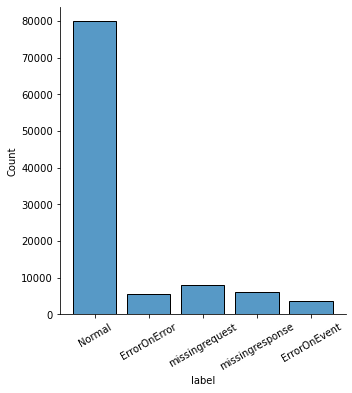

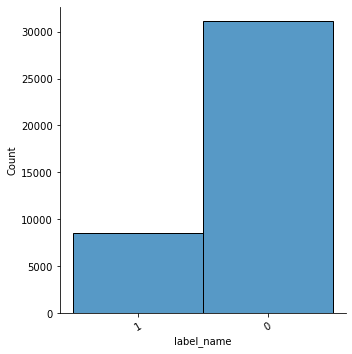

In [26]:
data_describe(d3)

## Sequence Description

x represents sequences of packets and y represents their label . 
Note : if a certain sequence contains 1 minimum abnormal packet it is considered as abnormal sequence. 
The pros and cons of this labeling will be discussed later.)

In [27]:
def sequence_describe(d):
    x,y=preprocess(d)
    
    # Normal And Abnormal Sequences
    sequences_length=np.zeros((len(x)))
    for i in range(len(sequences_length)):
        sequences_length[i]= x[i].shape[0]
    sequences=pd.DataFrame(sequences_length, columns=['length'])
    #dataframe["length"].value_counts()
    

    # Abnormal Sequences
    ind=np.zeros(len(y[y==1]))
    j=0
    for i in range(len(y)):
        if (y[i]==1):
            ind[j]=i
            j+=1

    ind=ind.astype(int)
    sequencesab_length=np.zeros((len(ind)))
    for i in range(len(ind)):
        sequencesab_length[i]= x[ind[i]].shape[0]
    sequencesab=pd.DataFrame(sequencesab_length, columns=['length'])
    #dataframe["length"].value_counts()
    
    
    #normal Sequences
    indn=np.zeros(len(y[y==0]))
    j=0
    for i in range(len(y)):
        if (y[i]==0):
            indn[j]=i
            j+=1

    indn=indn.astype(int)
    sequencesn_length=np.zeros((len(indn)))
    for i in range(len(indn)):
        sequencesn_length[i]= x[indn[i]].shape[0]
    sequencesn=pd.DataFrame(sequencesn_length, columns=['length'])

    ax = sns.boxplot(x=sequences["length"])
    
    g1=sns.displot(sequences,x="length")
    g1.set_xticklabels(rotation=30)
    g2=sns.displot(sequencesab,x="length")
    g2.set_xticklabels(rotation=30)
    
    sns.displot(sequences, x="length", kind="kde")
    sns.displot(sequencesab, x="length", kind="kde")
    
    #sequences.plot.pie(autopct="%.1f%%");
    
    
    
    print(" Normal Sequences unique length and their number \n" + str(sequencesn["length"].value_counts()))
    print(" Abnormal Sequences unique length and their number \n" + str(sequencesab["length"].value_counts()))
    
    

 Normal Sequences unique length and their number 
1.0     16911
2.0      9149
4.0      3388
6.0       915
3.0       321
8.0       265
10.0       65
12.0       15
5.0         9
20.0        7
14.0        7
16.0        5
22.0        5
66.0        4
32.0        4
18.0        4
46.0        4
50.0        4
48.0        3
26.0        3
54.0        3
36.0        3
38.0        3
64.0        2
34.0        2
24.0        2
42.0        2
60.0        2
40.0        1
68.0        1
86.0        1
28.0        1
52.0        1
62.0        1
30.0        1
Name: length, dtype: int64
 Abnormal Sequences unique length and their number 
2.0      3595
3.0      2020
5.0       773
4.0       734
6.0       242
         ... 
128.0       1
98.0        1
51.0        1
126.0       1
184.0       1
Name: length, Length: 74, dtype: int64


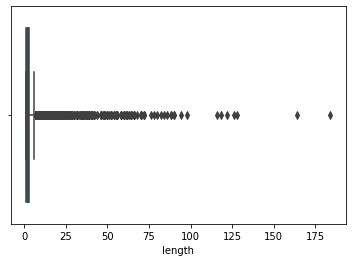

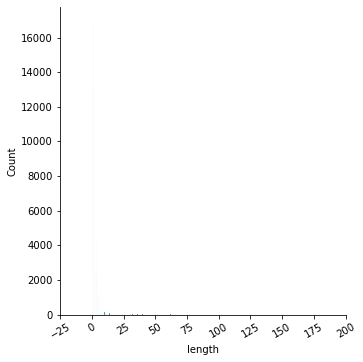

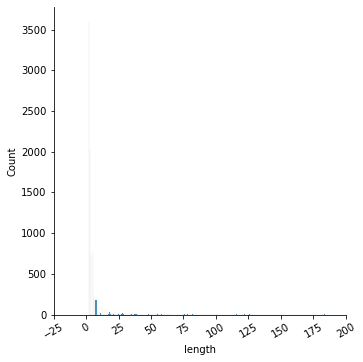

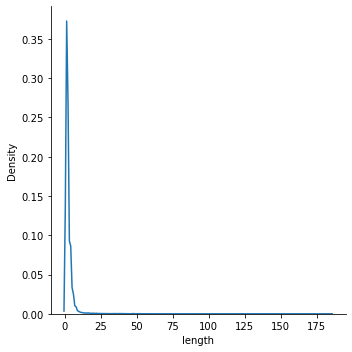

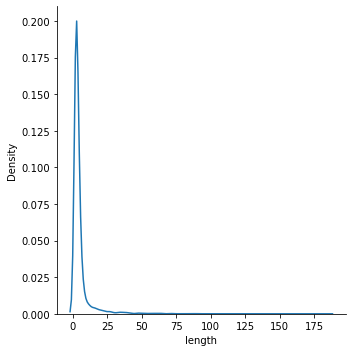

In [28]:
sequence_describe(d3)

In [29]:
def data_cleaning(d1):
    x,y=preprocess(d1)
    sequences_length=np.zeros((len(x)))
    for i in range(len(sequences_length)):
        sequences_length[i]= x[i].shape[0]
    sequences=pd.DataFrame(sequences_length, columns=['length'])
    m=sequences["length"].value_counts()
    m.index=m.index.astype(int)
    k=pd.DataFrame(m)
    k["sequence_length"]=k.index
    k["number"]=k["length"]
    k.drop(columns=["length"],inplace=True)
    k.reset_index(drop=True,inplace=True)
    
    
    ind=np.zeros(len(y[y==1]))
    j=0
    for i in range(len(y)):
        if (y[i]==1):
            ind[j]=i
            j+=1

    ind=ind.astype(int)
    sequencesab_length=np.zeros((len(ind)))
    for i in range(len(ind)):
        sequencesab_length[i]= x[ind[i]].shape[0]
    sequencesab=pd.DataFrame(sequencesab_length, columns=['length'])
    f=sequencesab["length"].value_counts()
    f.index=f.index.astype(int)
    l=pd.DataFrame(f)
    l["sequence_length"]=l.index
    l["number"]=l["length"]
    l.drop(columns=["length"],inplace=True)
    l.reset_index(drop=True,inplace=True)
    
    indn=np.zeros(len(y[y==0]))
    j=0
    for i in range(len(y)):
        if (y[i]==0):
            indn[j]=i
            j+=1

    indn=indn.astype(int)
    sequencesn_length=np.zeros((len(indn)))
    for i in range(len(indn)):
        sequencesn_length[i]= x[indn[i]].shape[0]
    sequencesn=pd.DataFrame(sequencesn_length, columns=['length'])
    b=sequencesn["length"].value_counts()
    b.index=b.index.astype(int)
    p=pd.DataFrame(b)
    p["sequence_length"]=p.index
    p["number"]=p["length"]
    p.drop(columns=["length"],inplace=True)
    p.reset_index(drop=True,inplace=True)
    
    
    common=pd.Series(list(set(l.iloc[0:10,0]).union(set(p.iloc[0:10,0]))))
    
    
    # input_size : number of examples to be fed into 
    input_size=0
    for i in common:
        input_size+=len(sequences[sequences["length"]==i])


    # max number of packets in a sequence
    max_packets=max(common)

    # size of features 

    feature_size = x[0].shape[1]


    # initialize
    x_new=np.zeros((input_size,max_packets,feature_size))
    y_new=np.zeros((input_size))


    # fill 

    j=0
    b=0
    for i in common:
        for j in range(len(x)):
            if (x[j].shape[0]==i):
                    for a in range(i):
                        x_new[b][a]=x[j][a]
                    y_new[b]=y[j]
                    b+=1

    return x_new,y_new,l,p
    

In [30]:
x_new,y_new,l,p=data_cleaning(d3)

# Data Visualization after cleaning 

In [31]:
def data_visualize(x,y):
    #perc= 100*(len(y[y==1])/len(y))
    #x,y=preprocess(df)
    print(
          "Sequence Analysis \n"
          "Number of sequences is " + str(len(x)) + "\n"
          "Number of abnormal sequences is " + str(len(y[y==1])) + "\n"
          "Number of features is " + str(x[0].shape[1]) + "\n"
          "Percentage of abnormal sequences is " + str(100*(len(y[y==1])/len(y))) + '\n')


    dataframe=pd.DataFrame(y, columns=['label'])
    dataframe['label_name'] = dataframe['label'].apply(lambda x: "1" if x==1 else "0")
    g2=sns.displot(dataframe,x="label_name")
    g2.set_xticklabels(rotation=30)
    

Sequence Analysis 
Number of sequences is 39071
Number of abnormal sequences is 8019
Number of features is 134
Percentage of abnormal sequences is 20.52417393975071



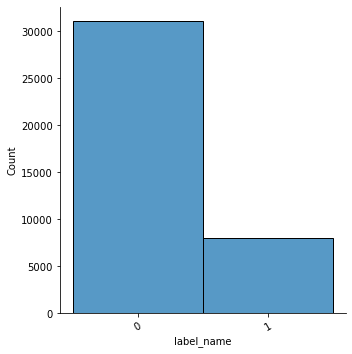

In [32]:
data_visualize(x_new,y_new)

In [33]:
x_new.shape

(39071, 20, 134)

# Machine Learning

In [34]:
from sklearn.utils import resample 

![title](img/s2v.png)

In [35]:
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Input, TimeDistributed, Dense, Activation, RepeatVector, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.preprocessing.sequence import pad_sequences

![title](img/s2v1.png)

# Numpy array to Dataframe

In [36]:
a=np.zeros((x_new.shape[0],x_new.shape[1]*x_new.shape[2]))
for i in range(len(x_new)):
    a[i]=x_new[i].ravel()
    
    
df = pd.DataFrame(a)
df["label"]=y_new
print(df['label'].value_counts())

0.0    31052
1.0     8019
Name: label, dtype: int64


In [37]:
from sklearn.model_selection import StratifiedKFold

In [38]:
from sklearn.metrics import confusion_matrix

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [40]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot

In [41]:
from tensorflow.keras.layers import Dropout

# Down-sample Majority Class

This time, the new DataFrame has fewer observations than the original, and the ratio of the two classes is now 1:1.

In [42]:
from sklearn.utils import resample

In [43]:
# Separate majority and minority classes
df_majority = df[df.label==0]
df_minority = df[df.label==1]


# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=len(df_minority),     # to match minority class
                                 random_state=123) # reproducible results



# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])


# Display new class counts
print(df_downsampled.label.value_counts())

y_ds=df_downsampled["label"]

x_ds=np.zeros((len(df_downsampled),x_new.shape[1],x_new.shape[2]))
print(x_ds.shape)

for i in range(len(df_downsampled)):
    x_ds[i]=df_downsampled.iloc[i,:-1].to_numpy().reshape((20,134))
    
    
y_ds.reset_index(drop=True,inplace=True)


c_normal=[]
c_abnormal=[]
for i in range(len(x_ds)):
    
    count_normal=0
    count_abnormal=0
    
    if(y_ds[i]==1):
        for j in x_ds[i]:
            if(sum(j)!= 0):
                    count_abnormal+=1
        c_abnormal.append(count_abnormal)
        
        

    if(y_ds[i]==0):
        for j in x_ds[i]:
            if(sum(j)!= 0):
                    count_normal+=1
        c_normal.append(count_normal)
        
        
        
set(c_normal)
set(c_abnormal)



pd.Series(c_normal).value_counts()
pd.Series(c_abnormal).value_counts()

0.0    8019
1.0    8019
Name: label, dtype: int64
(16038, 20, 134)


2     3595
3     2020
5      773
4      734
6      242
8      177
7      175
10     111
12      90
14      66
20      36
dtype: int64

In [44]:
df

,0,1,2,3,4,5,6,7,8,9,...,2671,2672,2673,2674,2675,2676,2677,2678,2679,label
0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39066,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
39067,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
39068,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
39069,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


In [45]:
df.to_csv("df_downsampled.csv")

Sequence Analysis 
Number of sequences is 16038
Number of abnormal sequences is 8019
Number of features is 134
Percentage of abnormal sequences is 50.0



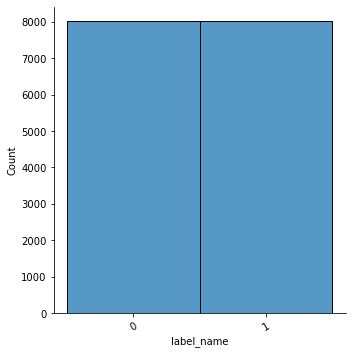

In [46]:
data_visualize(x_ds,y_ds)

In [47]:
import pickle as pkl
with open('x_ds.pkl','wb') as f: pkl.dump(x_ds, f)
with open('y_ds.pkl','wb') as f: pkl.dump(y_ds, f)

# Cross Validation

84/84 [==============================] - 1s 8ms/step - loss: 0.0153 - accuracy: 0.9963
accuracy: 99.63%
 Fall out is 0.0
 Miss rate is 0.0074850299401197605
84/84 [==============================] - 1s 8ms/step - loss: 0.0159 - accuracy: 0.9959
accuracy: 99.59%
 Fall out is 0.0
 Miss rate is 0.008233532934131737
84/84 [==============================] - 1s 8ms/step - loss: 0.0246 - accuracy: 0.9929
accuracy: 99.29%
 Fall out is 0.0007479431563201197
 Miss rate is 0.01347305389221557
84/84 [==============================] - 1s 8ms/step - loss: 0.0171 - accuracy: 0.9966
accuracy: 99.66%
 Fall out is 0.0007485029940119761
 Miss rate is 0.005983545250560957
84/84 [==============================] - 1s 8ms/step - loss: 0.0225 - accuracy: 0.9940
accuracy: 99.40%
 Fall out is 0.0007485029940119761
 Miss rate is 0.011219147344801795
84/84 [==============================] - 1s 8ms/step - loss: 0.0211 - accuracy: 0.9940
accuracy: 99.40%
 Fall out is 0.0
 Miss rate is 0.011967090501121914


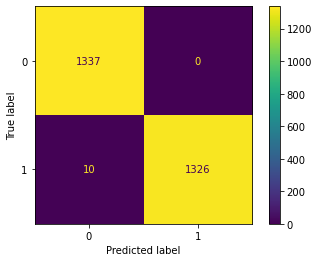

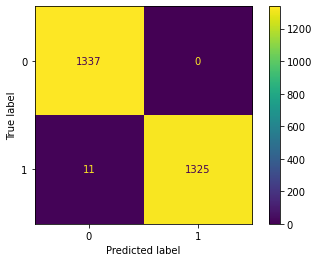

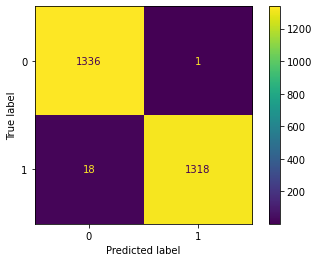

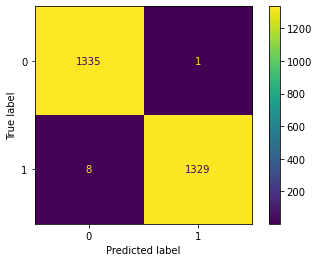

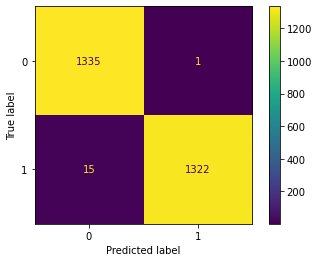

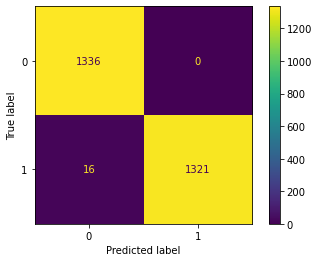

In [107]:
# fix random seed for reproducibility
seed = 7


# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=seed)

cvscores = []


for train, test in kfold.split(x_ds, y_ds):
    # create model
    model= Sequential([LSTM(20,return_sequences=True,input_shape=[None,x_ds.shape[2]]),
           LSTM(10),Dense(1, activation='sigmoid')])

    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    # Fit the model
    history=model.fit(x_ds[train], y_ds[train], epochs=41,batch_size=)
    # evaluate the model
    scores = model.evaluate(x_ds[test], y_ds[test])
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    
    y_pred = model.predict_classes(x_ds[test])
    cm=confusion_matrix(y_ds[test], y_pred)
    
    tn, fp, fn, tp = cm.ravel()
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot() 
    
    fpr=fp/(fp+tn)
    print(" Fall out is " + str(fpr))

    fnr=fn/(fn+tp)
    print(" Miss rate is " + str(fnr))
    
    cvscores.append(scores[1] * 100)

# Balanced Training and Testing Set

TRAIN: [ 1592 15431  1734 ...  2306  5703 12020] TEST: [ 3320 11496  1604 ... 14127 10585  6610]
Sequence Analysis 
Number of sequences is 1604
Number of abnormal sequences is 802
Number of features is 134
Percentage of abnormal sequences is 50.0

Sequence Analysis 
Number of sequences is 14434
Number of abnormal sequences is 7217
Number of features is 134
Percentage of abnormal sequences is 50.0



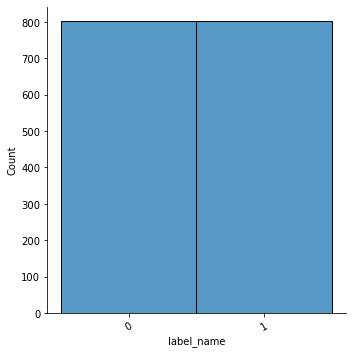

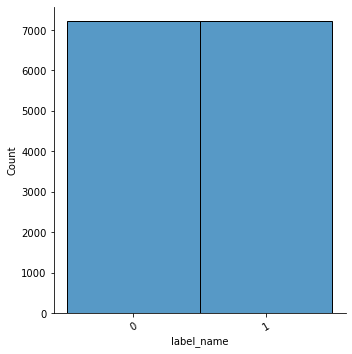

In [46]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=120)
sss.get_n_splits(x_ds, y_ds)

for train_idx, test_idx in sss.split(x_ds, y_ds):
    print("TRAIN:", train_idx, "TEST:", test_idx)
    X_train, X_test=x_ds[train_idx], x_ds[test_idx]
    y_train, y_test=y_ds[train_idx], y_ds[test_idx]
    
    
    
    
def sequences(x_ds,y_ds):


    c_normal=[]
    c_abnormal=[]
    for i in range(len(x_ds)):

        count_normal=0
        count_abnormal=0

        if(y_ds[i]==1):
            for j in x_ds[i]:
                if(sum(j)!= 0):
                        count_abnormal+=1
            c_abnormal.append(count_abnormal)



        if(y_ds[i]==0):
            for j in x_ds[i]:
                if(sum(j)!= 0):
                        count_normal+=1
            c_normal.append(count_normal)



    set(c_normal)
    set(c_abnormal)



    pd.Series(c_normal).value_counts()
    pd.Series(c_abnormal).value_counts()
    
    
    return c_normal,c_abnormal


    
y_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

c_normal,c_abnormal=sequences(X_train,y_train)
c_normal,c_abnormal=sequences(X_test,y_test)


pd.Series(c_normal).value_counts()
pd.Series(c_abnormal).value_counts()

data_visualize(X_test,y_test)
data_visualize(X_train,y_train)

In [84]:
type(X_train)

numpy.ndarray

In [88]:
X_train.shape

(14434, 20, 134)

# Saving Data

In [51]:
import pickle as pkl

In [55]:
with open('X_train.pkl','rb') as f: X_train = pkl.load(f)

In [54]:
with open('y_test.pkl','rb') as f: y_test = pkl.load(f)
with open('y_train.pkl','rb') as f: y_train = pkl.load(f)
with open('X_test.pkl','rb') as f: X_test = pkl.load(f)

# Baseline Model

In [56]:
from tensorflow.keras.callbacks import EarlyStopping

In [57]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [58]:
from tensorflow.keras.models import load_model

In [59]:
import numpy

## Reproducible results

In [60]:
import numpy as np
import tensorflow as tf
import random as rn

In [61]:
import os
os.environ['PYTHONHASHSEED'] = '0'

In [62]:
np.random.seed(37)

In [63]:
rn.seed(1254)

In [64]:
tf.random.set_seed(89)

In [67]:
tf.random.set_seed(89)
rn.seed(1254)
np.random.seed(37)

In [68]:

import pickle as pkl
from tensorflow import keras
model1 = keras.models.load_model('LSTM2010.h5')

with open('y_test.pkl','rb') as f: y_test = pkl.load(f)
with open('X_test.pkl','rb') as f: X_test = pkl.load(f)


scores = model1.evaluate(X_test, y_test)
print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))



UnknownError:    Fail to find the dnn implementation.
	 [[{{node CudnnRNN}}]]
	 [[sequential/lstm/PartitionedCall]] [Op:__inference_test_function_7647]

Function call stack:
test_function -> test_function -> test_function


In [66]:
model= Sequential([LSTM(20,return_sequences=True,input_shape=[None,x_ds.shape[2]]),
           LSTM(10),Dense(1, activation='sigmoid')])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# Fit the model


# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('LSTM2010.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)


history=model.fit(X_train, y_train, epochs=1000,batch_size=1024,validation_data=(X_test, y_test),callbacks=[es,mc])
# evaluate the model
#saved_model = load_model('best_model.h5')

scores = model.evaluate(X_test, y_test)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

y_pred = model.predict_classes(X_test)
cm=confusion_matrix(y_test, y_pred)

tn, fp, fn, tp = cm.ravel()

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot() 

fpr=fp/(fp+tn)
print(" Fall out is " + str(fpr))

fnr=fn/(fn+tp)
print(" Miss rate is " + str(fnr))

Epoch 1/1000


UnknownError:    Fail to find the dnn implementation.
	 [[{{node CudnnRNN}}]]
	 [[sequential/lstm/PartitionedCall]] [Op:__inference_train_function_5455]

Function call stack:
train_function -> train_function -> train_function


In [101]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, None, 20)          12400     
_________________________________________________________________
lstm_5 (LSTM)                (None, 10)                1240      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 13,651
Trainable params: 13,651
Non-trainable params: 0
_________________________________________________________________
None


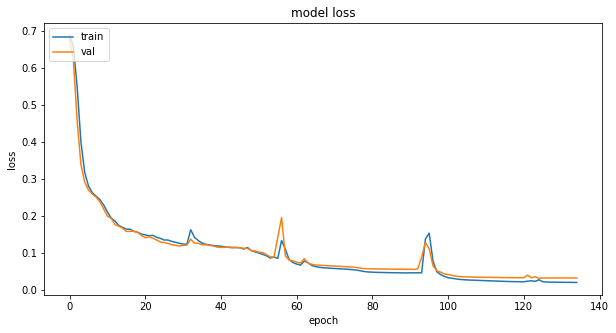

In [126]:
from matplotlib import pyplot as plt
history.history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

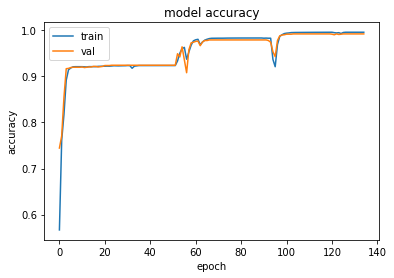

In [127]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.legend(['train','val'], loc='upper left')
plt.show()

# Keras Tuner

## Neuron Number

In [129]:
# import time
LOG_DIR = f"{int(time.time())}"


import kerastuner as kt

def model_builder1(hp):
    
    tf.random.set_seed(89)
    rn.seed(1254)
    np.random.seed(37)
    
    model1 = Sequential()


    model1.add(
        LSTM
        (hp.Int('units1',
                                min_value=20,
                                max_value=40,
                                step=5)
         ,return_sequences=True,
         input_shape=[None,x_ds.shape[2]]
       
                   
             
                    
                ))
        
    
    




    model1.add(
        LSTM
        (
          hp.Int('units2',
                                min_value=10,
                                max_value=30,
                                step=5)
            
            
      
                    
                    
                ))
    
    




    model1.add( Dense (1,activation="sigmoid"))

    model1.compile(
                optimizer='adam'
                ,
                loss='binary_crossentropy',
                metrics=['accuracy']
            )
    

    return model1

tuner = RandomSearch(
    model_builder1,
    objective='val_accuracy', 
    max_trials=1000,  # how many model variations to test?
    executions_per_trial=1, 
     # how many trials per variation? (same model could perform differently)
    directory=LOG_DIR)


# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('tune_model_dropout.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)


tuner.search(x=X_train,
             y=y_train,
              # just slapping this here bc jupyter notebook. The console out was getting messy.
             epochs=1000,
             batch_size=1024,
             #callbacks=[tensorboard],  # if you have callbacks like tensorboard, they go here.
             validation_data=(X_test, y_test),callbacks=[es,mc])

Trial 18 Complete [00h 07m 00s]
val_accuracy: 0.9918952584266663

Best val_accuracy So Far: 0.9937655925750732
Total elapsed time: 01h 56m 20s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [139]:
tuner.results_summary(18)

Results summary
Results in 1614886465\untitled_project
Showing 18 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
units1: 35
units2: 10
Score: 0.9937655925750732
Trial summary
Hyperparameters:
units1: 40
units2: 25
Score: 0.9931421279907227
Trial summary
Hyperparameters:
units1: 40
units2: 15
Score: 0.9925187230110168
Trial summary
Hyperparameters:
units1: 25
units2: 20
Score: 0.9925187230110168
Trial summary
Hyperparameters:
units1: 35
units2: 25
Score: 0.9925187230110168
Trial summary
Hyperparameters:
units1: 30
units2: 30
Score: 0.9925187230110168
Trial summary
Hyperparameters:
units1: 20
units2: 25
Score: 0.9918952584266663
Trial summary
Hyperparameters:
units1: 25
units2: 10
Score: 0.9918952584266663
Trial summary
Hyperparameters:
units1: 40
units2: 10
Score: 0.9918952584266663
Trial summary
Hyperparameters:
units1: 35
units2: 15
Score: 0.9918952584266663
Trial summary
Hyperparameters:
units1: 20
units2: 15
Score: 0.9918952584266663
Trial

In [136]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 20, 'max_value': 40, 'step': 5, 'sampling': None}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 30, 'step': 5, 'sampling': None}


In [140]:
tuner.get_best_hyperparameters()[0].values

{'units1': 35, 'units2': 10}

In [147]:
# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

In [149]:
# Evaluate the best model.
loss, accuracy = best_model.evaluate(X_test, y_test)

51/51 [==============================] - 1s 15ms/step - loss: 0.0304 - accuracy: 0.9938


In [150]:
accuracy

0.9937655925750732

## Save Tuner model pickle

In [154]:
with open(f"units.pkl", "wb") as f:
    pkl.dump(tuner, f)

In [2]:

tuner = pkl.load(open("units.pkl","rb"))

AttributeError: Can't get attribute 'model_builder1' on <module '__main__'>

In [1]:
import pickle as pkl
import tensorflow as tf
import kerastuner as kt


with open('X_train.pkl','rb') as f: X_train = pkl.load(f)
with open('y_test.pkl','rb') as f: y_test = pkl.load(f)
with open('y_train.pkl','rb') as f: y_train = pkl.load(f)
with open('X_test.pkl','rb') as f: X_test = pkl.load(f)



tuner = pkl.load(open("units.pkl","rb"))

print(tuner.get_best_hyperparameters()[0].values)

# Retrieve the best model.
print(tuner1.get_best_models(num_models=1)[0].evaluate(X_test, y_test))



AttributeError: Can't get attribute 'model_builder1' on <module '__main__'>

In [155]:
tuner1 = pkl.load(open("units.pkl","rb"))

tuner1.get_best_hyperparameters()[0].values

{'units1': 35, 'units2': 10}

In [157]:
# Retrieve the best model.
tuner1.get_best_models(num_models=1)[0].evaluate(X_test, y_test)

51/51 [==============================] - 1s 16ms/step - loss: 0.0304 - accuracy: 0.9938


[0.030377505347132683, 0.9937655925750732]

# Dropout

In [ ]:
import pickle as pkl

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import numpy

import numpy as np
import tensorflow as tf
import random as rn

tf.random.set_seed(89)
rn.seed(1254)
np.random.seed(37)

from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Input, TimeDistributed, Dense, Activation, RepeatVector, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.preprocessing.sequence import pad_sequences


from kerastuner.tuners import RandomSearch
from kerastuner.engine.hypermodel import HyperModel
from kerastuner.engine.hyperparameters import HyperParameters
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from tensorflow.keras.layers import Dropout

from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

with open('X_train.pkl','rb') as f: X_train = pkl.load(f)
with open('y_test.pkl','rb') as f: y_test = pkl.load(f)
with open('y_train.pkl','rb') as f: y_train = pkl.load(f)
with open('X_test.pkl','rb') as f: X_test = pkl.load(f)



import time
LOG_DIR = f"{int(time.time())}"


import kerastuner as kt

def model_builder1(hp):
    tf.random.set_seed(89)
    rn.seed(1254)
    np.random.seed(37)
    
    
    model = Sequential()


    model.add(
        LSTM
        (
            35
                    
         ,return_sequences=True,
         input_shape=[None,x_ds.shape[2]])
    )


    model.add(
                Dropout(rate=hp.Float(
                    'dropout_1',
                    min_value=0.1,
                    max_value=0.9,
                    default=0.25,
                    step=0.05,
                ))
            )

    model.add(
        LSTM
        (
            
                        10
                    
    )
    )



    model.add(
                Dropout(rate=hp.Float(
                    'dropout_2',
                    min_value=0.1,
                    max_value=0.9,
                    default=0.25,
                    step=0.05,
                ))
            )

    model.add( Dense (1,activation="sigmoid"))

    model.compile(
                optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy']
            )



    return model


es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

tuner = RandomSearch(
    model_builder1,
    objective='val_accuracy', 
    max_trials=1000,  # how many model variations to test?
    executions_per_trial=1, 
     # how many trials per variation? (same model could perform differently)
    directory=LOG_DIR)

tuner.search(x=X_train,
             y=y_train,
              # just slapping this here bc jupyter notebook. The console out was getting messy.
             epochs=1000,
             batch_size=1024,
             #callbacks=[tensorboard],  # if you have callbacks like tensorboard, they go here.
             validation_data=(X_test, y_test),callbacks=[es])


tuner.results_summary()


with open(f"dropout.pkl", "wb") as f:
    pkl.dump(tuner, f)


In [ ]:
import time
LOG_DIR = f"{int(time.time())}"

import kerastuner as kt

def model_builder1(hp):
    tf.random.set_seed(89)
    rn.seed(1254)
    np.random.seed(37)
    
    
    
    
    model = Sequential()


    model.add(
        LSTM
        (
            35
                    
         ,return_sequences=True,
         input_shape=[None,x_ds.shape[2]])
    )


    model.add(
                Dropout(rate=hp.Float(
                    'dropout_1',
                    min_value=0.1,
                    max_value=0.9,
                    default=0.25,
                    step=0.05,
                ))
            )

    model.add(
        LSTM
        (
            
                        10
                    
    )
    )



    model.add(
                Dropout(rate=hp.Float(
                    'dropout_2',
                    min_value=0.1,
                    max_value=0.9,
                    default=0.25,
                    step=0.05,
                ))
            )

    model.add( Dense (1,activation="sigmoid"))

    model.compile(
                optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy']
            )



    return model


es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

tuner = RandomSearch(
    model_builder1,
    objective='val_accuracy', 
    max_trials=1000,  # how many model variations to test?
    executions_per_trial=1, 
     # how many trials per variation? (same model could perform differently)
    directory=LOG_DIR)

tuner.search(x=X_train,
             y=y_train,
              # just slapping this here bc jupyter notebook. The console out was getting messy.
             epochs=1000,
             batch_size=1024,
             #callbacks=[tensorboard],  # if you have callbacks like tensorboard, they go here.
             validation_data=(X_test, y_test),callbacks=[es])


tuner.results_summary()


with open(f"dropout.pkl", "wb") as f:
    pkl.dump(tuner, f)

Trial 78 Complete [00h 06m 12s]
val_accuracy: 0.9925187230110168

Best val_accuracy So Far: 0.9931421279907227
Total elapsed time: 16h 21m 33s

Search: Running Trial #79

Hyperparameter    |Value             |Best Value So Far 
dropout_1         |0.55              |0.25              
dropout_2         |0.4               |0.6               

Epoch 1/1000
15/15 [==============================] - 8s 566ms/step - loss: 0.6770 - accuracy: 0.6136 - val_loss: 0.6451 - val_accuracy: 0.7170
Epoch 2/1000
15/15 [==============================] - 7s 472ms/step - loss: 0.5932 - accuracy: 0.7858 - val_loss: 0.4880 - val_accuracy: 0.8747
Epoch 3/1000
15/15 [==============================] - 7s 493ms/step - loss: 0.4484 - accuracy: 0.8996 - val_loss: 0.3812 - val_accuracy: 0.9059
Epoch 4/1000
15/15 [==============================] - 7s 465ms/step - loss: 0.3707 - accuracy: 0.9107 - val_loss: 0.3102 - val_accuracy: 0.9165
Epoch 5/1000
15/15 [==============================] - 7s 437ms/step - loss: 0.320

15/15 [==============================] - 6s 433ms/step - loss: 0.0356 - accuracy: 0.9952 - val_loss: 0.0398 - val_accuracy: 0.9925
Epoch 112/1000
15/15 [==============================] - 6s 417ms/step - loss: 0.0350 - accuracy: 0.9954 - val_loss: 0.0396 - val_accuracy: 0.9925
Epoch 113/1000
15/15 [==============================] - 6s 421ms/step - loss: 0.0348 - accuracy: 0.9954 - val_loss: 0.0394 - val_accuracy: 0.9925
Epoch 114/1000
15/15 [==============================] - 6s 422ms/step - loss: 0.0347 - accuracy: 0.9955 - val_loss: 0.0393 - val_accuracy: 0.9925
Epoch 115/1000
15/15 [==============================] - 6s 422ms/step - loss: 0.0345 - accuracy: 0.9953 - val_loss: 0.0391 - val_accuracy: 0.9925
Epoch 116/1000
15/15 [==============================] - 6s 429ms/step - loss: 0.0344 - accuracy: 0.9953 - val_loss: 0.0389 - val_accuracy: 0.9925
Epoch 117/1000
15/15 [==============================] - 6s 428ms/step - loss: 0.0336 - accuracy: 0.9954 - val_loss: 0.0387 - val_accuracy: 

# Regularization

In [ ]:
import time
LOG_DIR = f"{int(time.time())}"


import kerastuner as kt

def model_builder1(hp):
    
    tf.random.set_seed(89)
    rn.seed(1254)
    np.random.seed(37)
    
    model1 = Sequential()


    model1.add(
        LSTM
        (35
         ,return_sequences=True,
         input_shape=[None,x_ds.shape[2]],
        kernel_regularizer=regularizers.l2(hp.Float(
                    'r1',
                    min_value=1e-2,
                    max_value=1e2,
                    sampling='LOG',
                    default=1e-2,
                   
             
                    
                ))
        )
    )
    




    model1.add(
        LSTM
        (
          10, 
            
            
            kernel_regularizer=regularizers.l2(hp.Float(
                    'r2',
                    min_value=1e-2,
                    max_value=1e2,
                    sampling='LOG',
                    default=1e-2,
                    
                    
                ))
    )
    )




    model1.add( Dense (1,activation="sigmoid"))

    model1.compile(
                optimizer='adam'
                ,
                loss='binary_crossentropy',
                metrics=['accuracy']
            )



    return model1

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)


tuner = RandomSearch(
    model_builder1,
    objective='val_accuracy', 
    max_trials=1000,  # how many model variations to test?
    executions_per_trial=1, 
     # how many trials per variation? (same model could perform differently)
    directory=LOG_DIR)

tuner.search(x=X_train,
             y=y_train,
              # just slapping this here bc jupyter notebook. The console out was getting messy.
             epochs=1000,
             batch_size=1024,
             #callbacks=[tensorboard],  # if you have callbacks like tensorboard, they go here.
             validation_data=(X_test, y_test))

tuner.results_summary()


with open(f"reg.pkl", "wb") as f:
    pkl.dump(tuner, f)

# Grid Search Regularization Hyperparameter

In [62]:
from tensorflow.keras.regularizers import l2

Epoch 1/1000
15/15 [==============================] - ETA: 0s - loss: 9.6483 - accuracy: 0.4505
Epoch 00001: val_accuracy improved from -inf to 0.49501, saving model to best_model.h5
15/15 [==============================] - 5s 330ms/step - loss: 9.6483 - accuracy: 0.4505 - val_loss: 8.3114 - val_accuracy: 0.4950
Epoch 2/1000
14/15 [===========================>..] - ETA: 0s - loss: 7.4257 - accuracy: 0.5437 ETA: 0s - loss: 8.0259 
Epoch 00002: val_accuracy improved from 0.49501 to 0.71820, saving model to best_model.h5
15/15 [==============================] - 2s 106ms/step - loss: 7.4193 - accuracy: 0.5446 - val_loss: 6.3632 - val_accuracy: 0.7182
Epoch 3/1000
14/15 [===========================>..] - ETA: 0s - loss: 5.6701 - accuracy: 0.6615 ETA: 0s - loss: 6.0314 - ac
Epoch 00003: val_accuracy improved from 0.71820 to 0.74626, saving model to best_model.h5
15/15 [==============================] - 2s 143ms/step - loss: 5.6650 - accuracy: 0.6623 - val_loss: 4.8411 - val_accuracy: 0.7463


Epoch 29/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.1776 - accuracy: 0.9217
Epoch 00029: val_accuracy did not improve from 0.92332
15/15 [==============================] - 2s 120ms/step - loss: 0.1778 - accuracy: 0.9216 - val_loss: 0.1767 - val_accuracy: 0.9196
Epoch 30/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.1732 - accuracy: 0.9220
Epoch 00030: val_accuracy did not improve from 0.92332
15/15 [==============================] - 2s 117ms/step - loss: 0.1729 - accuracy: 0.9222 - val_loss: 0.1660 - val_accuracy: 0.9221
Epoch 31/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.1692 - accuracy: 0.9229
Epoch 00031: val_accuracy did not improve from 0.92332
15/15 [==============================] - 2s 118ms/step - loss: 0.1691 - accuracy: 0.9226 - val_loss: 0.1653 - val_accuracy: 0.9221
Epoch 32/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.1683 - accuracy: 0.9227
Epoch 00032: val_accuracy did not improve from 0.92332

Epoch 9/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.2418 - accuracy: 0.9224
Epoch 00009: val_accuracy did not improve from 0.92145
15/15 [==============================] - 2s 105ms/step - loss: 0.2414 - accuracy: 0.9227 - val_loss: 0.2202 - val_accuracy: 0.9214
Epoch 10/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.2115 - accuracy: 0.9229
Epoch 00010: val_accuracy improved from 0.92145 to 0.92332, saving model to best_model.h5
15/15 [==============================] - 2s 113ms/step - loss: 0.2114 - accuracy: 0.9229 - val_loss: 0.1923 - val_accuracy: 0.9233
Epoch 11/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.1942 - accuracy: 0.9229
Epoch 00011: val_accuracy did not improve from 0.92332
15/15 [==============================] - 2s 110ms/step - loss: 0.1941 - accuracy: 0.9228 - val_loss: 0.1848 - val_accuracy: 0.9202
Epoch 12/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.1827 - accuracy: 0.9235
Epoch 00012: val_acc

Epoch 37/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.1070 - accuracy: 0.9746
Epoch 00037: val_accuracy did not improve from 0.97257
15/15 [==============================] - 2s 107ms/step - loss: 0.1067 - accuracy: 0.9748 - val_loss: 0.1034 - val_accuracy: 0.9726
Epoch 38/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.1026 - accuracy: 0.9765
Epoch 00038: val_accuracy improved from 0.97257 to 0.97319, saving model to best_model.h5
15/15 [==============================] - 2s 112ms/step - loss: 0.1028 - accuracy: 0.9764 - val_loss: 0.1015 - val_accuracy: 0.9732
Epoch 39/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.0998 - accuracy: 0.9768
Epoch 00039: val_accuracy did not improve from 0.97319
15/15 [==============================] - 2s 106ms/step - loss: 0.1002 - accuracy: 0.9767 - val_loss: 0.0999 - val_accuracy: 0.9726
Epoch 40/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.0981 - accuracy: 0.9768
Epoch 00040: val_ac

Epoch 66/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.0526 - accuracy: 0.9773
Epoch 00066: val_accuracy improved from 0.97382 to 0.97569, saving model to best_model.h5
15/15 [==============================] - 2s 116ms/step - loss: 0.0529 - accuracy: 0.9771 - val_loss: 0.0532 - val_accuracy: 0.9757
Epoch 67/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.0486 - accuracy: 0.9840
Epoch 00067: val_accuracy improved from 0.97569 to 0.98504, saving model to best_model.h5
15/15 [==============================] - 2s 117ms/step - loss: 0.0485 - accuracy: 0.9841 - val_loss: 0.0532 - val_accuracy: 0.9850
Epoch 68/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.0450 - accuracy: 0.9916
Epoch 00068: val_accuracy improved from 0.98504 to 0.99127, saving model to best_model.h5
15/15 [==============================] - 2s 116ms/step - loss: 0.0451 - accuracy: 0.9917 - val_loss: 0.0490 - val_accuracy: 0.9913
Epoch 69/1000
14/15 [=========================

14/15 [===========================>..] - ETA: 0s - loss: 0.1565 - accuracy: 0.9225
Epoch 00017: val_accuracy did not improve from 0.92207
15/15 [==============================] - 1s 99ms/step - loss: 0.1564 - accuracy: 0.9225 - val_loss: 0.1621 - val_accuracy: 0.9208
Epoch 18/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.1564 - accuracy: 0.9225
Epoch 00018: val_accuracy did not improve from 0.92207
15/15 [==============================] - 2s 101ms/step - loss: 0.1563 - accuracy: 0.9225 - val_loss: 0.1504 - val_accuracy: 0.9221
Epoch 19/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.1529 - accuracy: 0.9227
Epoch 00019: val_accuracy did not improve from 0.92207
15/15 [==============================] - 2s 104ms/step - loss: 0.1527 - accuracy: 0.9228 - val_loss: 0.1661 - val_accuracy: 0.9165
Epoch 20/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.1563 - accuracy: 0.9217
Epoch 00020: val_accuracy did not improve from 0.92207
15/15 [=======

Epoch 46/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.0894 - accuracy: 0.9762
Epoch 00046: val_accuracy did not improve from 0.97319
15/15 [==============================] - 1s 100ms/step - loss: 0.0895 - accuracy: 0.9762 - val_loss: 0.0890 - val_accuracy: 0.9732
Epoch 47/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.0880 - accuracy: 0.9763
Epoch 00047: val_accuracy did not improve from 0.97319
15/15 [==============================] - 2s 101ms/step - loss: 0.0878 - accuracy: 0.9764 - val_loss: 0.0878 - val_accuracy: 0.9732
Epoch 48/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.0861 - accuracy: 0.9768
Epoch 00048: val_accuracy did not improve from 0.97319
15/15 [==============================] - 1s 99ms/step - loss: 0.0863 - accuracy: 0.9768 - val_loss: 0.0867 - val_accuracy: 0.9732
Epoch 49/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.0855 - accuracy: 0.9767
Epoch 00049: val_accuracy did not improve from 0.97319


Epoch 75/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.0761 - accuracy: 0.9769
Epoch 00075: val_accuracy did not improve from 0.97319
15/15 [==============================] - 1s 100ms/step - loss: 0.0764 - accuracy: 0.9768 - val_loss: 0.0799 - val_accuracy: 0.9732
Epoch 76/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.0765 - accuracy: 0.9766
Epoch 00076: val_accuracy did not improve from 0.97319
15/15 [==============================] - 2s 101ms/step - loss: 0.0762 - accuracy: 0.9767 - val_loss: 0.0799 - val_accuracy: 0.9732
Epoch 77/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.0764 - accuracy: 0.9768
Epoch 00077: val_accuracy did not improve from 0.97319
15/15 [==============================] - 1s 99ms/step - loss: 0.0763 - accuracy: 0.9768 - val_loss: 0.0799 - val_accuracy: 0.9732
Epoch 78/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.0762 - accuracy: 0.9767
Epoch 00078: val_accuracy did not improve from 0.97319


Epoch 11/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.1732 - accuracy: 0.9222
Epoch 00011: val_accuracy improved from 0.91958 to 0.92269, saving model to best_model.h5
15/15 [==============================] - 2s 128ms/step - loss: 0.1729 - accuracy: 0.9224 - val_loss: 0.1579 - val_accuracy: 0.9227
Epoch 12/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.1629 - accuracy: 0.9230
Epoch 00012: val_accuracy improved from 0.92269 to 0.92332, saving model to best_model.h5
15/15 [==============================] - 2s 145ms/step - loss: 0.1630 - accuracy: 0.9230 - val_loss: 0.1499 - val_accuracy: 0.9233
Epoch 13/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.1578 - accuracy: 0.9232 ETA: 0s - loss: 0.1577 - accuracy: 0.92
Epoch 00013: val_accuracy did not improve from 0.92332
15/15 [==============================] - 2s 102ms/step - loss: 0.1576 - accuracy: 0.9232 - val_loss: 0.1473 - val_accuracy: 0.9233
Epoch 14/1000
14/15 [====================

Epoch 00067: early stopping
Param: 0.000010, Train: 0.978, Test: 0.974
51/51 [==============================] - 0s 8ms/step - loss: 0.0602 - accuracy: 0.9738
accuracy: 97.38%
 Fall out is 0.03865336658354115
 Miss rate is 0.01371571072319202
Epoch 1/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.6883 - accuracy: 0.5027
Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to best_model.h5
15/15 [==============================] - 4s 245ms/step - loss: 0.6883 - accuracy: 0.5021 - val_loss: 0.6789 - val_accuracy: 0.5000
Epoch 2/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.6636 - accuracy: 0.6485
Epoch 00002: val_accuracy improved from 0.50000 to 0.77057, saving model to best_model.h5
15/15 [==============================] - 2s 165ms/step - loss: 0.6636 - accuracy: 0.6490 - val_loss: 0.6391 - val_accuracy: 0.7706
Epoch 3/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.5876 - accuracy: 0.8152
Epoch 00003: val_accuracy impro

14/15 [===========================>..] - ETA: 0s - loss: 0.1275 - accuracy: 0.9247
Epoch 00028: val_accuracy did not improve from 0.92394
15/15 [==============================] - 1s 97ms/step - loss: 0.1278 - accuracy: 0.9241 - val_loss: 0.1219 - val_accuracy: 0.9239
Epoch 29/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.1251 - accuracy: 0.9242
Epoch 00029: val_accuracy did not improve from 0.92394
15/15 [==============================] - 1s 93ms/step - loss: 0.1253 - accuracy: 0.9242 - val_loss: 0.1199 - val_accuracy: 0.9239
Epoch 30/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.1222 - accuracy: 0.9291
Epoch 00030: val_accuracy improved from 0.92394 to 0.93703, saving model to best_model.h5
15/15 [==============================] - 2s 160ms/step - loss: 0.1222 - accuracy: 0.9293 - val_loss: 0.1247 - val_accuracy: 0.9370
Epoch 31/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.1230 - accuracy: 0.9426
Epoch 00031: val_accuracy improved 

Epoch 56/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.0643 - accuracy: 0.9777
Epoch 00056: val_accuracy did not improve from 0.97382
15/15 [==============================] - 1s 78ms/step - loss: 0.0645 - accuracy: 0.9776 - val_loss: 0.0686 - val_accuracy: 0.9738
Epoch 57/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.0643 - accuracy: 0.9775
Epoch 00057: val_accuracy did not improve from 0.97382
15/15 [==============================] - 1s 85ms/step - loss: 0.0640 - accuracy: 0.9776 - val_loss: 0.0685 - val_accuracy: 0.9738
Epoch 58/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.0638 - accuracy: 0.9775
Epoch 00058: val_accuracy did not improve from 0.97382
15/15 [==============================] - 1s 77ms/step - loss: 0.0637 - accuracy: 0.9776 - val_loss: 0.0686 - val_accuracy: 0.9732
Epoch 59/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.0634 - accuracy: 0.9775
Epoch 00059: val_accuracy did not improve from 0.97382
15

14/15 [===========================>..] - ETA: 0s - loss: 0.0291 - accuracy: 0.9911
Epoch 00084: val_accuracy did not improve from 0.98815
15/15 [==============================] - 1s 72ms/step - loss: 0.0290 - accuracy: 0.9912 - val_loss: 0.0375 - val_accuracy: 0.9869
Epoch 85/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.0282 - accuracy: 0.9918
Epoch 00085: val_accuracy did not improve from 0.98815
15/15 [==============================] - 1s 76ms/step - loss: 0.0281 - accuracy: 0.9919 - val_loss: 0.0377 - val_accuracy: 0.9869
Epoch 86/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.0266 - accuracy: 0.9920
Epoch 00086: val_accuracy improved from 0.98815 to 0.99065, saving model to best_model.h5
15/15 [==============================] - 3s 169ms/step - loss: 0.0270 - accuracy: 0.9919 - val_loss: 0.0355 - val_accuracy: 0.9906
Epoch 87/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.0256 - accuracy: 0.9930
Epoch 00087: val_accuracy did not i

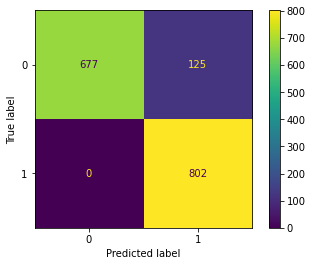

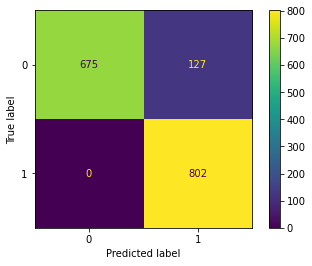

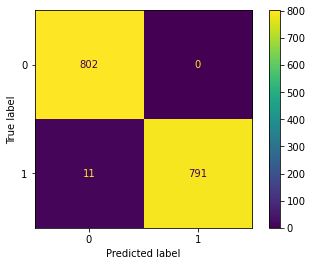

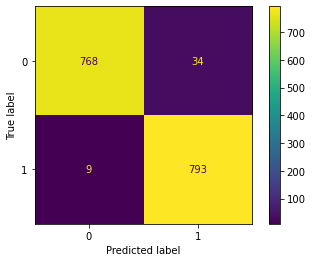

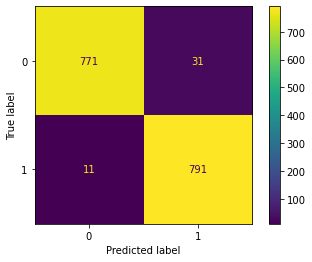

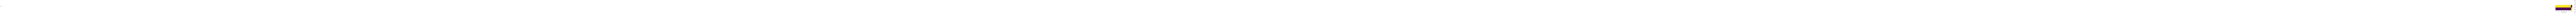

In [110]:
# grid search values
values = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
all_train, all_test = list(), list()
for param in values:
   
    
    model=Sequential([LSTM(20,return_sequences=True,input_shape=[None,x_ds.shape[2]],kernel_regularizer=l2(param)),
           LSTM(10),Dense(1, activation='sigmoid')])
    
    
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    
        # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
    
    
    history=model.fit(X_train, y_train, epochs=1000,batch_size=1024,validation_data=(X_test, y_test),callbacks=[es,mc])
    # evaluate the model
    saved_model = load_model('best_model.h5')
    
    # evaluate the model
    _, train_acc = model.evaluate(X_train, y_train, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print('Param: %f, Train: %.3f, Test: %.3f' % (param, train_acc, test_acc))
    all_train.append(train_acc)
    all_test.append(test_acc)

    scores = model.evaluate(X_test, y_test)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

    y_pred = model.predict_classes(X_test)
    cm=confusion_matrix(y_test, y_pred)

    tn, fp, fn, tp = cm.ravel()

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot() 

    fpr=fp/(fp+tn)
    print(" Fall out is " + str(fpr))

    fnr=fn/(fn+tp)
    print(" Miss rate is " + str(fnr))

    
    
# plot train and test means
pyplot.semilogx(values, all_train, label='train', marker='o')
pyplot.semilogx(values, all_test, label='test', marker='o')
pyplot.legend()
pyplot.show()

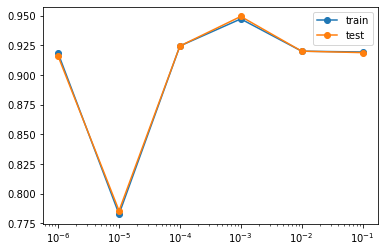

In [109]:
# plot train and test means
pyplot.semilogx(values, all_train, label='train', marker='o')
pyplot.semilogx(values, all_test, label='test', marker='o')
pyplot.legend()
pyplot.show()

# Grid Search Hyperparameter Tuning

In [ ]:
# grid search values
values = [1e-3, 1e-4, 1e-5, 1e-6]
all_train, all_test = list(), list()
r1,r2,r3= list(), list(), list()



for param in values:
    for k in values: 
        for j in values:
            model= Sequential([LSTM(20,return_sequences=True,input_shape=[None,x_ds.shape[2]],kernel_regularizer=l2(param)),
                   LSTM(10,kernel_regularizer=l2(k)),Dense(1, activation='sigmoid',kernel_regularizer=l2(j))])


            model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

                # simple early stopping
            es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
            mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)


            history=model.fit(X_train, y_train, epochs=1000,batch_size=1024,validation_data=(X_test, y_test),callbacks=[es,mc])
            # evaluate the model
            saved_model = load_model('best_model.h5')

            # evaluate the model
            _, train_acc = model.evaluate(X_train, y_train, verbose=0)
            _, test_acc = model.evaluate(X_test, y_test, verbose=0)
            print('Param: %f, Train: %.3f, Test: %.3f' % (param, train_acc, test_acc))
            all_train.append(train_acc)
            all_test.append(test_acc)
            r1.append(param)
            r2.append(k)
            r3.append(j)
  

Epoch 1/1000
15/15 [==============================] - 4s 74ms/step - loss: 0.8170 - accuracy: 0.5256 - val_loss: 0.7895 - val_accuracy: 0.6852

Epoch 00001: val_accuracy improved from -inf to 0.68516, saving model to best_model.h5
Epoch 2/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.7765 - accuracy: 0.6226 - val_loss: 0.7376 - val_accuracy: 0.6527

Epoch 00002: val_accuracy did not improve from 0.68516
Epoch 3/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.7156 - accuracy: 0.7178 - val_loss: 0.6303 - val_accuracy: 0.8466

Epoch 00003: val_accuracy improved from 0.68516 to 0.84663, saving model to best_model.h5
Epoch 4/1000
15/15 [==============================] - 0s 23ms/step - loss: 0.5832 - accuracy: 0.8559 - val_loss: 0.5001 - val_accuracy: 0.8716

Epoch 00004: val_accuracy improved from 0.84663 to 0.87157, saving model to best_model.h5
Epoch 5/1000
15/15 [==============================] - 0s 23ms/step - loss: 0.4706 - accuracy: 0.8910 -

15/15 [==============================] - 0s 25ms/step - loss: 0.0952 - accuracy: 0.9776 - val_loss: 0.1026 - val_accuracy: 0.9726

Epoch 00080: val_accuracy did not improve from 0.97257
Epoch 81/1000
15/15 [==============================] - 0s 25ms/step - loss: 0.1011 - accuracy: 0.9753 - val_loss: 0.1024 - val_accuracy: 0.9726

Epoch 00081: val_accuracy did not improve from 0.97257
Epoch 82/1000
15/15 [==============================] - 0s 24ms/step - loss: 0.0963 - accuracy: 0.9764 - val_loss: 0.1020 - val_accuracy: 0.9726

Epoch 00082: val_accuracy did not improve from 0.97257
Epoch 83/1000
15/15 [==============================] - 0s 23ms/step - loss: 0.0993 - accuracy: 0.9753 - val_loss: 0.1013 - val_accuracy: 0.9726

Epoch 00083: val_accuracy did not improve from 0.97257
Epoch 84/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.0979 - accuracy: 0.9761 - val_loss: 0.1011 - val_accuracy: 0.9726

Epoch 00084: val_accuracy did not improve from 0.97257
Epoch 85/1000



Epoch 00013: val_accuracy improved from 0.91958 to 0.92145, saving model to best_model.h5
Epoch 14/1000
15/15 [==============================] - 0s 24ms/step - loss: 0.1953 - accuracy: 0.9200 - val_loss: 0.1865 - val_accuracy: 0.9221

Epoch 00014: val_accuracy improved from 0.92145 to 0.92207, saving model to best_model.h5
Epoch 15/1000
15/15 [==============================] - 0s 24ms/step - loss: 0.1871 - accuracy: 0.9238 - val_loss: 0.1825 - val_accuracy: 0.9221

Epoch 00015: val_accuracy did not improve from 0.92207
Epoch 16/1000
15/15 [==============================] - 0s 24ms/step - loss: 0.1882 - accuracy: 0.9199 - val_loss: 0.1794 - val_accuracy: 0.9221

Epoch 00016: val_accuracy did not improve from 0.92207
Epoch 17/1000
15/15 [==============================] - 0s 24ms/step - loss: 0.1801 - accuracy: 0.9238 - val_loss: 0.1769 - val_accuracy: 0.9221

Epoch 00017: val_accuracy did not improve from 0.92207
Epoch 18/1000
15/15 [==============================] - 0s 26ms/step - loss

15/15 [==============================] - 0s 25ms/step - loss: 0.0967 - accuracy: 0.9775 - val_loss: 0.0961 - val_accuracy: 0.9732

Epoch 00053: val_accuracy improved from 0.97257 to 0.97319, saving model to best_model.h5
Epoch 54/1000
15/15 [==============================] - 0s 25ms/step - loss: 0.0969 - accuracy: 0.9756 - val_loss: 0.0959 - val_accuracy: 0.9726

Epoch 00054: val_accuracy did not improve from 0.97319
Epoch 55/1000
15/15 [==============================] - 0s 24ms/step - loss: 0.0937 - accuracy: 0.9765 - val_loss: 0.0949 - val_accuracy: 0.9726

Epoch 00055: val_accuracy did not improve from 0.97319
Epoch 56/1000
15/15 [==============================] - 0s 25ms/step - loss: 0.0897 - accuracy: 0.9787 - val_loss: 0.0928 - val_accuracy: 0.9732

Epoch 00056: val_accuracy did not improve from 0.97319
Epoch 57/1000
15/15 [==============================] - 0s 24ms/step - loss: 0.0904 - accuracy: 0.9778 - val_loss: 0.0926 - val_accuracy: 0.9732

Epoch 00057: val_accuracy did not 


Epoch 00093: val_accuracy did not improve from 0.97756
Epoch 94/1000
15/15 [==============================] - ETA: 0s - loss: 0.0615 - accuracy: 0.97 - 0s 23ms/step - loss: 0.0614 - accuracy: 0.9796 - val_loss: 0.0641 - val_accuracy: 0.9782

Epoch 00094: val_accuracy improved from 0.97756 to 0.97818, saving model to best_model.h5
Epoch 95/1000
15/15 [==============================] - 0s 24ms/step - loss: 0.0589 - accuracy: 0.9828 - val_loss: 0.0798 - val_accuracy: 0.9738

Epoch 00095: val_accuracy did not improve from 0.97818
Epoch 96/1000
15/15 [==============================] - 0s 24ms/step - loss: 0.0674 - accuracy: 0.9810 - val_loss: 0.0759 - val_accuracy: 0.9813

Epoch 00096: val_accuracy improved from 0.97818 to 0.98130, saving model to best_model.h5
Epoch 97/1000
15/15 [==============================] - 0s 23ms/step - loss: 0.0708 - accuracy: 0.9774 - val_loss: 0.0618 - val_accuracy: 0.9794

Epoch 00097: val_accuracy did not improve from 0.98130
Epoch 98/1000
15/15 [===========

15/15 [==============================] - 0s 21ms/step - loss: 0.1509 - accuracy: 0.9228 - val_loss: 0.1473 - val_accuracy: 0.9227

Epoch 00048: val_accuracy did not improve from 0.92332
Epoch 49/1000
15/15 [==============================] - 0s 23ms/step - loss: 0.1538 - accuracy: 0.9219 - val_loss: 0.1470 - val_accuracy: 0.9227

Epoch 00049: val_accuracy did not improve from 0.92332
Epoch 50/1000
15/15 [==============================] - 0s 22ms/step - loss: 0.1495 - accuracy: 0.9237 - val_loss: 0.1466 - val_accuracy: 0.9227

Epoch 00050: val_accuracy did not improve from 0.92332
Epoch 51/1000
15/15 [==============================] - 0s 23ms/step - loss: 0.1528 - accuracy: 0.9194 - val_loss: 0.1461 - val_accuracy: 0.9227

Epoch 00051: val_accuracy did not improve from 0.92332
Epoch 52/1000
15/15 [==============================] - 0s 23ms/step - loss: 0.1500 - accuracy: 0.9249 - val_loss: 0.1457 - val_accuracy: 0.9227

Epoch 00052: val_accuracy did not improve from 0.92332
Epoch 53/1000



Epoch 00058: val_accuracy did not improve from 0.92207
Epoch 59/1000
15/15 [==============================] - 0s 23ms/step - loss: 0.1517 - accuracy: 0.9236 - val_loss: 0.1500 - val_accuracy: 0.9221

Epoch 00059: val_accuracy did not improve from 0.92207
Epoch 60/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.1498 - accuracy: 0.9232 - val_loss: 0.1498 - val_accuracy: 0.9221

Epoch 00060: val_accuracy did not improve from 0.92207
Epoch 61/1000
15/15 [==============================] - 0s 20ms/step - loss: 0.1499 - accuracy: 0.9239 - val_loss: 0.1496 - val_accuracy: 0.9221

Epoch 00061: val_accuracy did not improve from 0.92207
Epoch 62/1000
15/15 [==============================] - 0s 23ms/step - loss: 0.1521 - accuracy: 0.9231 - val_loss: 0.1491 - val_accuracy: 0.9221

Epoch 00062: val_accuracy did not improve from 0.92207
Epoch 63/1000
15/15 [==============================] - 0s 23ms/step - loss: 0.1547 - accuracy: 0.9220 - val_loss: 0.1486 - val_accuracy: 0.9221


Epoch 15/1000
15/15 [==============================] - 0s 26ms/step - loss: 0.1702 - accuracy: 0.9242 - val_loss: 0.1608 - val_accuracy: 0.9233

Epoch 00015: val_accuracy did not improve from 0.92332
Epoch 16/1000
15/15 [==============================] - 0s 24ms/step - loss: 0.1742 - accuracy: 0.9267 - val_loss: 0.1662 - val_accuracy: 0.9227

Epoch 00016: val_accuracy did not improve from 0.92332
Epoch 17/1000
15/15 [==============================] - 0s 24ms/step - loss: 0.1714 - accuracy: 0.9242 - val_loss: 0.1573 - val_accuracy: 0.9233

Epoch 00017: val_accuracy did not improve from 0.92332
Epoch 18/1000
15/15 [==============================] - 0s 25ms/step - loss: 0.1662 - accuracy: 0.9239 - val_loss: 0.1524 - val_accuracy: 0.9239

Epoch 00018: val_accuracy improved from 0.92332 to 0.92394, saving model to best_model.h5
Epoch 19/1000
15/15 [==============================] - 0s 26ms/step - loss: 0.1611 - accuracy: 0.9242 - val_loss: 0.1503 - val_accuracy: 0.9239

Epoch 00019: val_acc


Epoch 00053: val_accuracy did not improve from 0.99252
Epoch 54/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.0524 - accuracy: 0.9942 - val_loss: 0.0521 - val_accuracy: 0.9931

Epoch 00054: val_accuracy improved from 0.99252 to 0.99314, saving model to best_model.h5
Epoch 55/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.0499 - accuracy: 0.9943 - val_loss: 0.0515 - val_accuracy: 0.9931

Epoch 00055: val_accuracy did not improve from 0.99314
Epoch 56/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.0480 - accuracy: 0.9948 - val_loss: 0.0509 - val_accuracy: 0.9931

Epoch 00056: val_accuracy did not improve from 0.99314
Epoch 57/1000
15/15 [==============================] - 0s 22ms/step - loss: 0.0452 - accuracy: 0.9959 - val_loss: 0.0503 - val_accuracy: 0.9925

Epoch 00057: val_accuracy did not improve from 0.99314
Epoch 58/1000
15/15 [==============================] - ETA: 0s - loss: 0.0452 - accuracy: 0.99 - 0s 21ms/step

15/15 [==============================] - 0s 22ms/step - loss: 0.1497 - accuracy: 0.9218 - val_loss: 0.1432 - val_accuracy: 0.9233

Epoch 00032: val_accuracy did not improve from 0.92332
Epoch 33/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.1472 - accuracy: 0.9235 - val_loss: 0.1421 - val_accuracy: 0.9233

Epoch 00033: val_accuracy did not improve from 0.92332
Epoch 34/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.1447 - accuracy: 0.9255 - val_loss: 0.1410 - val_accuracy: 0.9233

Epoch 00034: val_accuracy did not improve from 0.92332
Epoch 35/1000
15/15 [==============================] - 0s 23ms/step - loss: 0.1459 - accuracy: 0.9236 - val_loss: 0.1405 - val_accuracy: 0.9233

Epoch 00035: val_accuracy did not improve from 0.92332
Epoch 36/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.1419 - accuracy: 0.9248 - val_loss: 0.1398 - val_accuracy: 0.9233

Epoch 00036: val_accuracy did not improve from 0.92332
Epoch 37/1000


15/15 [==============================] - 0s 20ms/step - loss: 0.0471 - accuracy: 0.9908 - val_loss: 0.0482 - val_accuracy: 0.9888

Epoch 00110: val_accuracy did not improve from 0.99002
Epoch 111/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.0441 - accuracy: 0.9927 - val_loss: 0.0447 - val_accuracy: 0.9919

Epoch 00111: val_accuracy improved from 0.99002 to 0.99190, saving model to best_model.h5
Epoch 112/1000
15/15 [==============================] - 0s 20ms/step - loss: 0.0430 - accuracy: 0.9935 - val_loss: 0.0547 - val_accuracy: 0.9863

Epoch 00112: val_accuracy did not improve from 0.99190
Epoch 113/1000
15/15 [==============================] - 0s 20ms/step - loss: 0.0756 - accuracy: 0.9753 - val_loss: 0.0638 - val_accuracy: 0.9838

Epoch 00113: val_accuracy did not improve from 0.99190
Epoch 114/1000
15/15 [==============================] - 0s 20ms/step - loss: 0.0610 - accuracy: 0.9845 - val_loss: 0.0486 - val_accuracy: 0.9906

Epoch 00114: val_accuracy did 


Epoch 00013: val_accuracy improved from 0.92269 to 0.92332, saving model to best_model.h5
Epoch 14/1000
15/15 [==============================] - 0s 23ms/step - loss: 0.1715 - accuracy: 0.9206 - val_loss: 0.1575 - val_accuracy: 0.9233

Epoch 00014: val_accuracy did not improve from 0.92332
Epoch 15/1000
15/15 [==============================] - 0s 26ms/step - loss: 0.1616 - accuracy: 0.9252 - val_loss: 0.1552 - val_accuracy: 0.9233

Epoch 00015: val_accuracy did not improve from 0.92332
Epoch 16/1000
15/15 [==============================] - 0s 24ms/step - loss: 0.1645 - accuracy: 0.9229 - val_loss: 0.1535 - val_accuracy: 0.9233 0s - loss: 0.1653 - accuracy: 0.

Epoch 00016: val_accuracy did not improve from 0.92332
Epoch 17/1000
15/15 [==============================] - 0s 24ms/step - loss: 0.1635 - accuracy: 0.9210 - val_loss: 0.1658 - val_accuracy: 0.9208

Epoch 00017: val_accuracy did not improve from 0.92332
Epoch 18/1000
15/15 [==============================] - 0s 23ms/step - loss: 

15/15 [==============================] - 0s 23ms/step - loss: 0.0334 - accuracy: 0.9937 - val_loss: 0.0450 - val_accuracy: 0.9913

Epoch 00093: val_accuracy did not improve from 0.99190
Epoch 94/1000
15/15 [==============================] - 0s 23ms/step - loss: 0.0356 - accuracy: 0.9934 - val_loss: 0.0422 - val_accuracy: 0.9925

Epoch 00094: val_accuracy improved from 0.99190 to 0.99252, saving model to best_model.h5
Epoch 95/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.0349 - accuracy: 0.9932 - val_loss: 0.0441 - val_accuracy: 0.9913

Epoch 00095: val_accuracy did not improve from 0.99252
Epoch 96/1000
15/15 [==============================] - 0s 23ms/step - loss: 0.0308 - accuracy: 0.9952 - val_loss: 0.0370 - val_accuracy: 0.9919

Epoch 00096: val_accuracy did not improve from 0.99252
Epoch 97/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.0298 - accuracy: 0.9953 - val_loss: 0.0390 - val_accuracy: 0.9913

Epoch 00097: val_accuracy did not 


Epoch 00065: val_accuracy did not improve from 0.95387
Epoch 66/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.1152 - accuracy: 0.9494 - val_loss: 0.1131 - val_accuracy: 0.9545

Epoch 00066: val_accuracy improved from 0.95387 to 0.95449, saving model to best_model.h5
Epoch 67/1000
15/15 [==============================] - 0s 20ms/step - loss: 0.1093 - accuracy: 0.9581 - val_loss: 0.1093 - val_accuracy: 0.9539

Epoch 00067: val_accuracy did not improve from 0.95449
Epoch 68/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.1033 - accuracy: 0.9607 - val_loss: 0.1048 - val_accuracy: 0.9632

Epoch 00068: val_accuracy improved from 0.95449 to 0.96322, saving model to best_model.h5
Epoch 69/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.1014 - accuracy: 0.9651 - val_loss: 0.1039 - val_accuracy: 0.9651

Epoch 00069: val_accuracy improved from 0.96322 to 0.96509, saving model to best_model.h5
Epoch 70/1000
15/15 [==================

15/15 [==============================] - 0s 23ms/step - loss: 0.0507 - accuracy: 0.9925 - val_loss: 0.0556 - val_accuracy: 0.9900

Epoch 00104: val_accuracy did not improve from 0.99252
Epoch 105/1000
15/15 [==============================] - 0s 23ms/step - loss: 0.0485 - accuracy: 0.9932 - val_loss: 0.0502 - val_accuracy: 0.9919

Epoch 00105: val_accuracy did not improve from 0.99252
Epoch 106/1000
15/15 [==============================] - 0s 23ms/step - loss: 0.0474 - accuracy: 0.9931 - val_loss: 0.0481 - val_accuracy: 0.9925

Epoch 00106: val_accuracy did not improve from 0.99252
Epoch 107/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.0482 - accuracy: 0.9933 - val_loss: 0.0482 - val_accuracy: 0.9919

Epoch 00107: val_accuracy did not improve from 0.99252
Epoch 108/1000
15/15 [==============================] - 0s 23ms/step - loss: 0.0476 - accuracy: 0.9941 - val_loss: 0.0493 - val_accuracy: 0.9906

Epoch 00108: val_accuracy did not improve from 0.99252
Epoch 109/

Epoch 5/1000
15/15 [==============================] - 0s 23ms/step - loss: 0.3839 - accuracy: 0.9122 - val_loss: 0.3353 - val_accuracy: 0.9177

Epoch 00005: val_accuracy improved from 0.91209 to 0.91771, saving model to best_model.h5
Epoch 6/1000
15/15 [==============================] - 0s 24ms/step - loss: 0.3257 - accuracy: 0.9172 - val_loss: 0.2997 - val_accuracy: 0.9190

Epoch 00006: val_accuracy improved from 0.91771 to 0.91895, saving model to best_model.h5
Epoch 7/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.2983 - accuracy: 0.9173 - val_loss: 0.2773 - val_accuracy: 0.9208

Epoch 00007: val_accuracy improved from 0.91895 to 0.92082, saving model to best_model.h5
Epoch 8/1000
15/15 [==============================] - 0s 24ms/step - loss: 0.2748 - accuracy: 0.9200 - val_loss: 0.2580 - val_accuracy: 0.9208

Epoch 00008: val_accuracy did not improve from 0.92082
Epoch 9/1000
15/15 [==============================] - 0s 23ms/step - loss: 0.2563 - accuracy: 0.920

15/15 [==============================] - 0s 21ms/step - loss: 0.1516 - accuracy: 0.9259 - val_loss: 0.1469 - val_accuracy: 0.9233

Epoch 00045: val_accuracy did not improve from 0.92332
Epoch 46/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.1512 - accuracy: 0.9246 - val_loss: 0.1467 - val_accuracy: 0.9233

Epoch 00046: val_accuracy did not improve from 0.92332
Epoch 47/1000
15/15 [==============================] - 0s 22ms/step - loss: 0.1496 - accuracy: 0.9255 - val_loss: 0.1466 - val_accuracy: 0.9233

Epoch 00047: val_accuracy did not improve from 0.92332
Epoch 48/1000
15/15 [==============================] - 0s 23ms/step - loss: 0.1541 - accuracy: 0.9220 - val_loss: 0.1463 - val_accuracy: 0.9233

Epoch 00048: val_accuracy did not improve from 0.92332
Epoch 49/1000
15/15 [==============================] - 0s 23ms/step - loss: 0.1532 - accuracy: 0.9228 - val_loss: 0.1462 - val_accuracy: 0.9233s - loss: 0.1540 - accuracy: 0.

Epoch 00049: val_accuracy did not impr

15/15 [==============================] - 0s 21ms/step - loss: 0.1593 - accuracy: 0.9252 - val_loss: 0.1531 - val_accuracy: 0.9227

Epoch 00019: val_accuracy did not improve from 0.92269
Epoch 20/1000
15/15 [==============================] - 0s 20ms/step - loss: 0.1620 - accuracy: 0.9232 - val_loss: 0.1541 - val_accuracy: 0.9227

Epoch 00020: val_accuracy did not improve from 0.92269
Epoch 21/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.1588 - accuracy: 0.9237 - val_loss: 0.1529 - val_accuracy: 0.9227

Epoch 00021: val_accuracy did not improve from 0.92269
Epoch 22/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.1556 - accuracy: 0.9249 - val_loss: 0.2639 - val_accuracy: 0.9090

Epoch 00022: val_accuracy did not improve from 0.92269
Epoch 23/1000
15/15 [==============================] - 0s 23ms/step - loss: 0.2169 - accuracy: 0.9172 - val_loss: 0.1970 - val_accuracy: 0.9208

Epoch 00023: val_accuracy did not improve from 0.92269
Epoch 24/1000


15/15 [==============================] - 0s 23ms/step - loss: 0.1504 - accuracy: 0.9262 - val_loss: 0.1458 - val_accuracy: 0.9239

Epoch 00027: val_accuracy did not improve from 0.92394
Epoch 28/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.1458 - accuracy: 0.9290 - val_loss: 0.1436 - val_accuracy: 0.9239

Epoch 00028: val_accuracy did not improve from 0.92394
Epoch 29/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.1474 - accuracy: 0.9264 - val_loss: 0.1427 - val_accuracy: 0.9239

Epoch 00029: val_accuracy did not improve from 0.92394
Epoch 30/1000
15/15 [==============================] - 0s 22ms/step - loss: 0.1486 - accuracy: 0.9225 - val_loss: 0.1422 - val_accuracy: 0.9239

Epoch 00030: val_accuracy did not improve from 0.92394
Epoch 31/1000
15/15 [==============================] - 0s 23ms/step - loss: 0.1457 - accuracy: 0.9249 - val_loss: 0.1416 - val_accuracy: 0.9239

Epoch 00031: val_accuracy did not improve from 0.92394
Epoch 32/1000


15/15 [==============================] - 0s 24ms/step - loss: 0.0442 - accuracy: 0.9946 - val_loss: 0.0466 - val_accuracy: 0.9931

Epoch 00106: val_accuracy did not improve from 0.99314
Epoch 107/1000
15/15 [==============================] - 0s 23ms/step - loss: 0.0469 - accuracy: 0.9949 - val_loss: 0.0466 - val_accuracy: 0.9931

Epoch 00107: val_accuracy did not improve from 0.99314
Epoch 108/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.0461 - accuracy: 0.9951 - val_loss: 0.0470 - val_accuracy: 0.9925

Epoch 00108: val_accuracy did not improve from 0.99314
Epoch 109/1000
15/15 [==============================] - 0s 23ms/step - loss: 0.0454 - accuracy: 0.9945 - val_loss: 0.0461 - val_accuracy: 0.9925

Epoch 00109: val_accuracy did not improve from 0.99314
Epoch 110/1000
15/15 [==============================] - 0s 23ms/step - loss: 0.0453 - accuracy: 0.9944 - val_loss: 0.0455 - val_accuracy: 0.9931

Epoch 00110: val_accuracy did not improve from 0.99314
Epoch 111/

15/15 [==============================] - 0s 21ms/step - loss: 0.0371 - accuracy: 0.9941 - val_loss: 0.9961 - val_accuracy: 0.6353

Epoch 00147: val_accuracy did not improve from 0.99314
Epoch 148/1000
15/15 [==============================] - 0s 21ms/step - loss: 1.2897 - accuracy: 0.4758 - val_loss: 0.8183 - val_accuracy: 0.5000

Epoch 00148: val_accuracy did not improve from 0.99314
Epoch 149/1000
15/15 [==============================] - 0s 23ms/step - loss: 0.8167 - accuracy: 0.4994 - val_loss: 0.7952 - val_accuracy: 0.5000

Epoch 00149: val_accuracy did not improve from 0.99314
Epoch 150/1000
15/15 [==============================] - 0s 23ms/step - loss: 0.7957 - accuracy: 0.4964 - val_loss: 0.7745 - val_accuracy: 0.5000

Epoch 00150: val_accuracy did not improve from 0.99314
Epoch 151/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.7696 - accuracy: 0.5011 - val_loss: 0.7560 - val_accuracy: 0.5000

Epoch 00151: val_accuracy did not improve from 0.99314
Epoch 152/

Epoch 31/1000
15/15 [==============================] - 0s 22ms/step - loss: 0.0891 - accuracy: 0.9699 - val_loss: 0.0686 - val_accuracy: 0.9726

Epoch 00031: val_accuracy did not improve from 0.97444
Epoch 32/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.0669 - accuracy: 0.9764 - val_loss: 0.0663 - val_accuracy: 0.9776

Epoch 00032: val_accuracy improved from 0.97444 to 0.97756, saving model to best_model.h5
Epoch 33/1000
15/15 [==============================] - 0s 20ms/step - loss: 0.0621 - accuracy: 0.9821 - val_loss: 0.0603 - val_accuracy: 0.9863

Epoch 00033: val_accuracy improved from 0.97756 to 0.98628, saving model to best_model.h5
Epoch 34/1000
15/15 [==============================] - 0s 22ms/step - loss: 0.0551 - accuracy: 0.9871 - val_loss: 0.0575 - val_accuracy: 0.9863

Epoch 00034: val_accuracy did not improve from 0.98628
Epoch 35/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.0508 - accuracy: 0.9890 - val_loss: 0.0530 - val_acc

15/15 [==============================] - 0s 21ms/step - loss: 0.1925 - accuracy: 0.9200 - val_loss: 0.1571 - val_accuracy: 0.9233

Epoch 00038: val_accuracy did not improve from 0.92394
Epoch 39/1000
15/15 [==============================] - ETA: 0s - loss: 0.1560 - accuracy: 0.92 - 0s 23ms/step - loss: 0.1565 - accuracy: 0.9246 - val_loss: 0.1562 - val_accuracy: 0.9233

Epoch 00039: val_accuracy did not improve from 0.92394
Epoch 40/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.1601 - accuracy: 0.9208 - val_loss: 0.1491 - val_accuracy: 0.9233

Epoch 00040: val_accuracy did not improve from 0.92394
Epoch 41/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.1528 - accuracy: 0.9228 - val_loss: 0.1418 - val_accuracy: 0.9239

Epoch 00041: val_accuracy did not improve from 0.92394
Epoch 42/1000
15/15 [==============================] - 0s 23ms/step - loss: 0.1486 - accuracy: 0.9237 - val_loss: 0.1390 - val_accuracy: 0.9239

Epoch 00042: val_accuracy d

15/15 [==============================] - ETA: 0s - loss: 0.1181 - accuracy: 0.93 - 0s 21ms/step - loss: 0.1181 - accuracy: 0.9303 - val_loss: 0.1192 - val_accuracy: 0.9333

Epoch 00078: val_accuracy did not improve from 0.93454
Epoch 79/1000
15/15 [==============================] - 0s 24ms/step - loss: 0.1187 - accuracy: 0.9305 - val_loss: 0.1173 - val_accuracy: 0.9339

Epoch 00079: val_accuracy did not improve from 0.93454
Epoch 80/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.1196 - accuracy: 0.9298 - val_loss: 0.1175 - val_accuracy: 0.9339

Epoch 00080: val_accuracy did not improve from 0.93454
Epoch 81/1000
15/15 [==============================] - 0s 20ms/step - loss: 0.2082 - accuracy: 0.8418 - val_loss: 0.2441 - val_accuracy: 0.9227

Epoch 00081: val_accuracy did not improve from 0.93454
Epoch 82/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.1829 - accuracy: 0.9225 - val_loss: 0.1566 - val_accuracy: 0.9202

Epoch 00082: val_accuracy d

15/15 [==============================] - 0s 21ms/step - loss: 0.0465 - accuracy: 0.9951 - val_loss: 0.0485 - val_accuracy: 0.9931

Epoch 00117: val_accuracy did not improve from 0.99314
Epoch 118/1000
15/15 [==============================] - 0s 23ms/step - loss: 0.0452 - accuracy: 0.9954 - val_loss: 0.0481 - val_accuracy: 0.9931

Epoch 00118: val_accuracy did not improve from 0.99314
Epoch 119/1000
15/15 [==============================] - 0s 24ms/step - loss: 0.0437 - accuracy: 0.9961 - val_loss: 0.0489 - val_accuracy: 0.9925

Epoch 00119: val_accuracy did not improve from 0.99314
Epoch 120/1000
15/15 [==============================] - 0s 23ms/step - loss: 0.0445 - accuracy: 0.9954 - val_loss: 0.0470 - val_accuracy: 0.9931

Epoch 00120: val_accuracy did not improve from 0.99314
Epoch 121/1000
15/15 [==============================] - 0s 23ms/step - loss: 0.0449 - accuracy: 0.9944 - val_loss: 0.0466 - val_accuracy: 0.9931

Epoch 00121: val_accuracy did not improve from 0.99314
Epoch 122/

15/15 [==============================] - 0s 21ms/step - loss: 0.2002 - accuracy: 0.9213 - val_loss: 0.1868 - val_accuracy: 0.9227

Epoch 00013: val_accuracy did not improve from 0.92269
Epoch 14/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.1879 - accuracy: 0.9213 - val_loss: 0.1740 - val_accuracy: 0.9227

Epoch 00014: val_accuracy did not improve from 0.92269
Epoch 15/1000
15/15 [==============================] - 0s 20ms/step - loss: 0.1785 - accuracy: 0.9222 - val_loss: 0.1652 - val_accuracy: 0.9227

Epoch 00015: val_accuracy did not improve from 0.92269
Epoch 16/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.1672 - accuracy: 0.9232 - val_loss: 0.1601 - val_accuracy: 0.9233

Epoch 00016: val_accuracy improved from 0.92269 to 0.92332, saving model to best_model.h5
Epoch 17/1000
15/15 [==============================] - ETA: 0s - loss: 0.1674 - accuracy: 0.92 - 0s 21ms/step - loss: 0.1672 - accuracy: 0.9208 - val_loss: 0.1579 - val_accuracy: 

15/15 [==============================] - 0s 23ms/step - loss: 0.2686 - accuracy: 0.9193 - val_loss: 0.2501 - val_accuracy: 0.9171

Epoch 00007: val_accuracy did not improve from 0.91895
Epoch 8/1000
15/15 [==============================] - 0s 24ms/step - loss: 0.2500 - accuracy: 0.9162 - val_loss: 0.2364 - val_accuracy: 0.9108

Epoch 00008: val_accuracy did not improve from 0.91895
Epoch 9/1000
15/15 [==============================] - 0s 24ms/step - loss: 0.2319 - accuracy: 0.9178 - val_loss: 0.2227 - val_accuracy: 0.9196

Epoch 00009: val_accuracy improved from 0.91895 to 0.91958, saving model to best_model.h5
Epoch 10/1000
15/15 [==============================] - 0s 24ms/step - loss: 0.2202 - accuracy: 0.9211 - val_loss: 0.2188 - val_accuracy: 0.9165

Epoch 00010: val_accuracy did not improve from 0.91958
Epoch 11/1000
15/15 [==============================] - 0s 24ms/step - loss: 0.2227 - accuracy: 0.9156 - val_loss: 0.2163 - val_accuracy: 0.9152

Epoch 00011: val_accuracy did not im

15/15 [==============================] - 0s 23ms/step - loss: 0.0640 - accuracy: 0.9748 - val_loss: 0.0634 - val_accuracy: 0.9707

Epoch 00046: val_accuracy did not improve from 0.97257
Epoch 47/1000
15/15 [==============================] - ETA: 0s - loss: 0.0618 - accuracy: 0.97 - 0s 21ms/step - loss: 0.0617 - accuracy: 0.9732 - val_loss: 0.0619 - val_accuracy: 0.9713

Epoch 00047: val_accuracy did not improve from 0.97257
Epoch 48/1000
15/15 [==============================] - 0s 23ms/step - loss: 0.0606 - accuracy: 0.9753 - val_loss: 0.0769 - val_accuracy: 0.9651

Epoch 00048: val_accuracy did not improve from 0.97257
Epoch 49/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.0743 - accuracy: 0.9695 - val_loss: 0.1081 - val_accuracy: 0.9620

Epoch 00049: val_accuracy did not improve from 0.97257
Epoch 50/1000
15/15 [==============================] - 0s 23ms/step - loss: 0.0915 - accuracy: 0.9648 - val_loss: 0.0761 - val_accuracy: 0.9682

Epoch 00050: val_accuracy d


Epoch 00008: val_accuracy did not improve from 0.91958
Epoch 9/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.2406 - accuracy: 0.9207 - val_loss: 0.2293 - val_accuracy: 0.9202

Epoch 00009: val_accuracy improved from 0.91958 to 0.92020, saving model to best_model.h5
Epoch 10/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.2230 - accuracy: 0.9235 - val_loss: 0.2173 - val_accuracy: 0.9202

Epoch 00010: val_accuracy did not improve from 0.92020
Epoch 11/1000
15/15 [==============================] - 0s 23ms/step - loss: 0.2089 - accuracy: 0.9248 - val_loss: 0.2018 - val_accuracy: 0.9221

Epoch 00011: val_accuracy improved from 0.92020 to 0.92207, saving model to best_model.h5
Epoch 12/1000
15/15 [==============================] - 0s 23ms/step - loss: 0.2004 - accuracy: 0.9243 - val_loss: 0.1892 - val_accuracy: 0.9227

Epoch 00012: val_accuracy improved from 0.92207 to 0.92269, saving model to best_model.h5
Epoch 13/1000
15/15 [===================

15/15 [==============================] - ETA: 0s - loss: 0.1517 - accuracy: 0.92 - 0s 21ms/step - loss: 0.1515 - accuracy: 0.9248 - val_loss: 0.1433 - val_accuracy: 0.9239

Epoch 00026: val_accuracy did not improve from 0.92394
Epoch 27/1000
15/15 [==============================] - 0s 23ms/step - loss: 0.1464 - accuracy: 0.9232 - val_loss: 0.1674 - val_accuracy: 0.9233

Epoch 00027: val_accuracy did not improve from 0.92394
Epoch 28/1000
15/15 [==============================] - 0s 23ms/step - loss: 0.1576 - accuracy: 0.9214 - val_loss: 0.1425 - val_accuracy: 0.9239

Epoch 00028: val_accuracy did not improve from 0.92394
Epoch 29/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.1475 - accuracy: 0.9208 - val_loss: 0.1354 - val_accuracy: 0.9239

Epoch 00029: val_accuracy did not improve from 0.92394
Epoch 30/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.1337 - accuracy: 0.9284 - val_loss: 0.1358 - val_accuracy: 0.9239

Epoch 00030: val_accuracy d


Epoch 00065: val_accuracy did not improve from 0.99190
Epoch 66/1000
15/15 [==============================] - 0s 23ms/step - loss: 0.0405 - accuracy: 0.9952 - val_loss: 0.0477 - val_accuracy: 0.9925

Epoch 00066: val_accuracy improved from 0.99190 to 0.99252, saving model to best_model.h5
Epoch 67/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.0384 - accuracy: 0.9957 - val_loss: 0.0473 - val_accuracy: 0.9925

Epoch 00067: val_accuracy did not improve from 0.99252
Epoch 68/1000
15/15 [==============================] - 0s 23ms/step - loss: 0.0385 - accuracy: 0.9958 - val_loss: 0.0471 - val_accuracy: 0.9925

Epoch 00068: val_accuracy did not improve from 0.99252
Epoch 69/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.0390 - accuracy: 0.9953 - val_loss: 0.0490 - val_accuracy: 0.9919

Epoch 00069: val_accuracy did not improve from 0.99252
Epoch 70/1000
15/15 [==============================] - 0s 23ms/step - loss: 0.0387 - accuracy: 0.9955 - val_l


Epoch 00012: val_accuracy did not improve from 0.91958
Epoch 13/1000
15/15 [==============================] - 0s 20ms/step - loss: 0.2054 - accuracy: 0.9209 - val_loss: 0.1947 - val_accuracy: 0.9202

Epoch 00013: val_accuracy improved from 0.91958 to 0.92020, saving model to best_model.h5
Epoch 14/1000
15/15 [==============================] - 0s 20ms/step - loss: 0.1957 - accuracy: 0.9206 - val_loss: 0.1848 - val_accuracy: 0.9214

Epoch 00014: val_accuracy improved from 0.92020 to 0.92145, saving model to best_model.h5
Epoch 15/1000
15/15 [==============================] - 0s 20ms/step - loss: 0.1854 - accuracy: 0.9211 - val_loss: 0.1728 - val_accuracy: 0.9227

Epoch 00015: val_accuracy improved from 0.92145 to 0.92269, saving model to best_model.h5
Epoch 16/1000
15/15 [==============================] - 0s 20ms/step - loss: 0.1764 - accuracy: 0.9227 - val_loss: 0.1713 - val_accuracy: 0.9214

Epoch 00016: val_accuracy did not improve from 0.92269
Epoch 17/1000
15/15 [==================

15/15 [==============================] - 0s 23ms/step - loss: 0.1502 - accuracy: 0.9237 - val_loss: 0.1725 - val_accuracy: 0.9239

Epoch 00037: val_accuracy did not improve from 0.92394
Epoch 38/1000
15/15 [==============================] - 0s 23ms/step - loss: 0.1763 - accuracy: 0.9202 - val_loss: 0.1631 - val_accuracy: 0.9196

Epoch 00038: val_accuracy did not improve from 0.92394
Epoch 39/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.1678 - accuracy: 0.9192 - val_loss: 0.1423 - val_accuracy: 0.9239

Epoch 00039: val_accuracy did not improve from 0.92394
Epoch 40/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.1499 - accuracy: 0.9228 - val_loss: 0.1424 - val_accuracy: 0.9239

Epoch 00040: val_accuracy did not improve from 0.92394
Epoch 41/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.1492 - accuracy: 0.9234 - val_loss: 0.1396 - val_accuracy: 0.9239

Epoch 00041: val_accuracy did not improve from 0.92394
Epoch 42/1000


15/15 [==============================] - 0s 23ms/step - loss: 0.0295 - accuracy: 0.9950 - val_loss: 0.0338 - val_accuracy: 0.9931

Epoch 00076: val_accuracy did not improve from 0.99314
Epoch 77/1000
15/15 [==============================] - 0s 23ms/step - loss: 0.0280 - accuracy: 0.9953 - val_loss: 0.0337 - val_accuracy: 0.9931

Epoch 00077: val_accuracy did not improve from 0.99314
Epoch 78/1000
15/15 [==============================] - ETA: 0s - loss: 0.0269 - accuracy: 0.99 - ETA: 0s - loss: 0.0269 - accuracy: 0.99 - 0s 21ms/step - loss: 0.0269 - accuracy: 0.9957 - val_loss: 0.0336 - val_accuracy: 0.9931

Epoch 00078: val_accuracy did not improve from 0.99314
Epoch 79/1000
15/15 [==============================] - 0s 23ms/step - loss: 0.0301 - accuracy: 0.9940 - val_loss: 0.0743 - val_accuracy: 0.9819

Epoch 00079: val_accuracy did not improve from 0.99314
Epoch 80/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.0788 - accuracy: 0.9746 - val_loss: 0.0522 - val_acc


Epoch 00116: val_accuracy did not improve from 0.99314
Epoch 117/1000
15/15 [==============================] - 0s 20ms/step - loss: 0.0288 - accuracy: 0.9944 - val_loss: 0.0317 - val_accuracy: 0.9931

Epoch 00117: val_accuracy did not improve from 0.99314
Epoch 118/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.0253 - accuracy: 0.9957 - val_loss: 0.0317 - val_accuracy: 0.9931

Epoch 00118: val_accuracy did not improve from 0.99314
Epoch 00118: early stopping
Param: 0.000100, Train: 0.995, Test: 0.993
Epoch 1/1000
15/15 [==============================] - 4s 72ms/step - loss: 0.7251 - accuracy: 0.6497 - val_loss: 0.7088 - val_accuracy: 0.7749

Epoch 00001: val_accuracy improved from -inf to 0.77494, saving model to best_model.h5
Epoch 2/1000
15/15 [==============================] - 0s 23ms/step - loss: 0.6975 - accuracy: 0.7683 - val_loss: 0.6556 - val_accuracy: 0.7749

Epoch 00002: val_accuracy did not improve from 0.77494
Epoch 3/1000
15/15 [=====================

15/15 [==============================] - 0s 21ms/step - loss: 0.1391 - accuracy: 0.9239 - val_loss: 0.1300 - val_accuracy: 0.9239

Epoch 00077: val_accuracy did not improve from 0.92394
Epoch 78/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.1296 - accuracy: 0.9246 - val_loss: 0.1291 - val_accuracy: 0.9239

Epoch 00078: val_accuracy did not improve from 0.92394
Epoch 79/1000
15/15 [==============================] - 0s 22ms/step - loss: 0.1299 - accuracy: 0.9232 - val_loss: 0.1224 - val_accuracy: 0.9246

Epoch 00079: val_accuracy improved from 0.92394 to 0.92456, saving model to best_model.h5
Epoch 80/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.1205 - accuracy: 0.9283 - val_loss: 0.1175 - val_accuracy: 0.9252

Epoch 00080: val_accuracy improved from 0.92456 to 0.92519, saving model to best_model.h5
Epoch 81/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.1283 - accuracy: 0.9226 - val_loss: 0.1203 - val_accuracy: 0.9246


In [ ]:
r1

In [ ]:
r2

In [ ]:
r3

In [43]:
s=np.arange(0.1,1,0.1)
s

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

# Varying Dropout

Epoch 1/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.6818 - accuracy: 0.6972
Epoch 00001: val_accuracy improved from -inf to 0.76683, saving model to best_model.h5
15/15 [==============================] - 4s 258ms/step - loss: 0.6817 - accuracy: 0.6976 - val_loss: 0.6695 - val_accuracy: 0.7668
Epoch 2/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.6500 - accuracy: 0.7664
Epoch 00002: val_accuracy improved from 0.76683 to 0.77494, saving model to best_model.h5
15/15 [==============================] - 2s 121ms/step - loss: 0.6501 - accuracy: 0.7658 - val_loss: 0.6153 - val_accuracy: 0.7749
Epoch 3/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.5679 - accuracy: 0.8470
Epoch 00003: val_accuracy improved from 0.77494 to 0.89963, saving model to best_model.h5
15/15 [==============================] - 2s 122ms/step - loss: 0.5671 - accuracy: 0.8476 - val_loss: 0.4967 - val_accuracy: 0.8996
Epoch 4/1000
14/15 [===========================>..] 

Epoch 29/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.2383 - accuracy: 0.9205
Epoch 00029: val_accuracy did not improve from 0.92332
15/15 [==============================] - 2s 109ms/step - loss: 0.2383 - accuracy: 0.9205 - val_loss: 0.2359 - val_accuracy: 0.9196
Epoch 30/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.2349 - accuracy: 0.9212
Epoch 00030: val_accuracy did not improve from 0.92332
15/15 [==============================] - 2s 113ms/step - loss: 0.2356 - accuracy: 0.9209 - val_loss: 0.2342 - val_accuracy: 0.9202
Epoch 31/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.2336 - accuracy: 0.9216
Epoch 00031: val_accuracy did not improve from 0.92332
15/15 [==============================] - 2s 117ms/step - loss: 0.2346 - accuracy: 0.9210 - val_loss: 0.2327 - val_accuracy: 0.9202
Epoch 32/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.2334 - accuracy: 0.9210
Epoch 00032: val_accuracy did not improve from 0.92332

Epoch 58/1000
15/15 [==============================] - ETA: 0s - loss: 0.1441 - accuracy: 0.9231
Epoch 00058: val_accuracy did not improve from 0.92394
15/15 [==============================] - 2s 121ms/step - loss: 0.1441 - accuracy: 0.9231 - val_loss: 0.1272 - val_accuracy: 0.9233
Epoch 59/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.1347 - accuracy: 0.9245
Epoch 00059: val_accuracy did not improve from 0.92394
15/15 [==============================] - 2s 122ms/step - loss: 0.1349 - accuracy: 0.9243 - val_loss: 0.1232 - val_accuracy: 0.9239
Epoch 60/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.1303 - accuracy: 0.9243
Epoch 00060: val_accuracy did not improve from 0.92394
15/15 [==============================] - 1s 93ms/step - loss: 0.1303 - accuracy: 0.9243 - val_loss: 0.1210 - val_accuracy: 0.9239
Epoch 61/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.1261 - accuracy: 0.9245
Epoch 00061: val_accuracy did not improve from 0.92394


Epoch 87/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.1081 - accuracy: 0.9234
Epoch 00087: val_accuracy did not improve from 0.92830
15/15 [==============================] - 1s 91ms/step - loss: 0.1078 - accuracy: 0.9237 - val_loss: 0.1070 - val_accuracy: 0.9239
Epoch 88/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.1101 - accuracy: 0.9229
Epoch 00088: val_accuracy did not improve from 0.92830
15/15 [==============================] - 2s 114ms/step - loss: 0.1102 - accuracy: 0.9229 - val_loss: 0.1132 - val_accuracy: 0.9214
Epoch 89/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.1152 - accuracy: 0.9193
Epoch 00089: val_accuracy did not improve from 0.92830
15/15 [==============================] - 2s 112ms/step - loss: 0.1152 - accuracy: 0.9192 - val_loss: 0.1169 - val_accuracy: 0.9239
Epoch 90/1000
14/15 [===========================>..] - ETA: 0s - loss: 0.1153 - accuracy: 0.9196
Epoch 00090: val_accuracy did not improve from 0.92830


KeyboardInterrupt: 

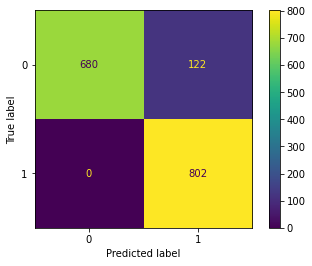

In [113]:
# grid search values
#values = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
values =np.arange(0.1,1,0.1)
all_train, all_test = list(), list()
for param in values:
    #model.add(Dense(500, input_dim=2, activation='relu', kernel_regularizer=l2(param)))
    
    model=Sequential([LSTM(20,return_sequences=True,input_shape=[None,x_ds.shape[2]]),
                                   Dropout(param),
           LSTM(10), Dropout(param), Dense(1, activation='sigmoid')])
    
    
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    
        # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
    
    
    history=model.fit(X_train, y_train, epochs=1000,batch_size=1024,validation_data=(X_test, y_test),callbacks=[es,mc])
    # evaluate the model
    saved_model = load_model('best_model.h5')
    
    # evaluate the model
    _, train_acc = model.evaluate(X_train, y_train, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print('Param: %f, Train: %.3f, Test: %.3f' % (param, train_acc, test_acc))
    all_train.append(train_acc)
    all_test.append(test_acc)

    scores = model.evaluate(X_test, y_test)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

    y_pred = model.predict_classes(X_test)
    cm=confusion_matrix(y_test, y_pred)

    tn, fp, fn, tp = cm.ravel()

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot() 

    fpr=fp/(fp+tn)
    print(" Fall out is " + str(fpr))

    fnr=fn/(fn+tp)
    print(" Miss rate is " + str(fnr))



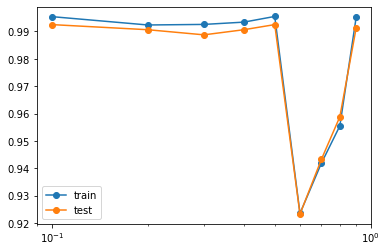

In [68]:
# plot train and test means
pyplot.semilogx(values, all_train, label='train', marker='o')
pyplot.semilogx(values, all_test, label='test', marker='o')
pyplot.legend()
pyplot.show()

Epoch 1/1000
15/15 [==============================] - 4s 67ms/step - loss: 0.6834 - accuracy: 0.5363 - val_loss: 0.6579 - val_accuracy: 0.7749

Epoch 00001: val_accuracy improved from -inf to 0.77494, saving model to best_model.h5
Epoch 2/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.6376 - accuracy: 0.7739 - val_loss: 0.5696 - val_accuracy: 0.8404

Epoch 00002: val_accuracy improved from 0.77494 to 0.84040, saving model to best_model.h5
Epoch 3/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.5172 - accuracy: 0.8711 - val_loss: 0.4099 - val_accuracy: 0.8385

Epoch 00003: val_accuracy did not improve from 0.84040
Epoch 4/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.3889 - accuracy: 0.8502 - val_loss: 0.3349 - val_accuracy: 0.8610

Epoch 00004: val_accuracy improved from 0.84040 to 0.86097, saving model to best_model.h5
Epoch 5/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.3290 - accuracy: 0.8627 -

C:\Users\natashakhatib\anaconda3\envs\mytensorv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


 Fall out is 0.003740648379052369
 Miss rate is 0.014962593516209476
Epoch 1/1000
15/15 [==============================] - 4s 67ms/step - loss: 0.6835 - accuracy: 0.6221 - val_loss: 0.6603 - val_accuracy: 0.7550

Epoch 00001: val_accuracy improved from -inf to 0.75499, saving model to best_model.h5
Epoch 2/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.6438 - accuracy: 0.7617 - val_loss: 0.5781 - val_accuracy: 0.7911

Epoch 00002: val_accuracy improved from 0.75499 to 0.79115, saving model to best_model.h5
Epoch 3/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.5378 - accuracy: 0.8292 - val_loss: 0.4262 - val_accuracy: 0.8741

Epoch 00003: val_accuracy improved from 0.79115 to 0.87406, saving model to best_model.h5
Epoch 4/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.3926 - accuracy: 0.8969 - val_loss: 0.3303 - val_accuracy: 0.9115

Epoch 00004: val_accuracy improved from 0.87406 to 0.91147, saving model to best_model.h

15/15 [==============================] - 0s 22ms/step - loss: 0.1681 - accuracy: 0.9219 - val_loss: 0.1318 - val_accuracy: 0.9239

Epoch 00040: val_accuracy did not improve from 0.92394
Epoch 41/1000
15/15 [==============================] - 0s 20ms/step - loss: 0.1340 - accuracy: 0.9236 - val_loss: 0.1174 - val_accuracy: 0.9239

Epoch 00041: val_accuracy did not improve from 0.92394
Epoch 42/1000
15/15 [==============================] - 0s 20ms/step - loss: 0.1244 - accuracy: 0.9236 - val_loss: 0.1151 - val_accuracy: 0.9239

Epoch 00042: val_accuracy did not improve from 0.92394
Epoch 43/1000
15/15 [==============================] - 0s 20ms/step - loss: 0.1194 - accuracy: 0.9217 - val_loss: 0.1093 - val_accuracy: 0.9239

Epoch 00043: val_accuracy did not improve from 0.92394
Epoch 44/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.1188 - accuracy: 0.9207 - val_loss: 0.1099 - val_accuracy: 0.9239

Epoch 00044: val_accuracy did not improve from 0.92394
Epoch 45/1000



Epoch 00079: val_accuracy did not improve from 0.96384
Epoch 80/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.0755 - accuracy: 0.9634 - val_loss: 0.0770 - val_accuracy: 0.9626

Epoch 00080: val_accuracy did not improve from 0.96384
Epoch 81/1000
15/15 [==============================] - 0s 23ms/step - loss: 0.0726 - accuracy: 0.9666 - val_loss: 0.0733 - val_accuracy: 0.9632

Epoch 00081: val_accuracy did not improve from 0.96384
Epoch 82/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.0720 - accuracy: 0.9654 - val_loss: 0.0735 - val_accuracy: 0.9645

Epoch 00082: val_accuracy improved from 0.96384 to 0.96446, saving model to best_model.h5
Epoch 83/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.0682 - accuracy: 0.9679 - val_loss: 0.0734 - val_accuracy: 0.9651

Epoch 00083: val_accuracy improved from 0.96446 to 0.96509, saving model to best_model.h5
Epoch 84/1000
15/15 [==============================] - 0s 21ms/step - loss

15/15 [==============================] - 0s 23ms/step - loss: 0.0252 - accuracy: 0.9932 - val_loss: 0.0301 - val_accuracy: 0.9913

Epoch 00157: val_accuracy did not improve from 0.99190
Epoch 158/1000
15/15 [==============================] - 0s 23ms/step - loss: 0.0255 - accuracy: 0.9934 - val_loss: 0.0290 - val_accuracy: 0.9913

Epoch 00158: val_accuracy did not improve from 0.99190
Epoch 159/1000
15/15 [==============================] - 0s 23ms/step - loss: 0.0269 - accuracy: 0.9922 - val_loss: 0.0281 - val_accuracy: 0.9919

Epoch 00159: val_accuracy did not improve from 0.99190
Epoch 160/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.0267 - accuracy: 0.9925 - val_loss: 0.0295 - val_accuracy: 0.9913

Epoch 00160: val_accuracy did not improve from 0.99190
Epoch 161/1000
15/15 [==============================] - 0s 23ms/step - loss: 0.0262 - accuracy: 0.9927 - val_loss: 0.0299 - val_accuracy: 0.9906

Epoch 00161: val_accuracy did not improve from 0.99190
Epoch 162/

15/15 [==============================] - 0s 23ms/step - loss: 0.0247 - accuracy: 0.9929 - val_loss: 0.0270 - val_accuracy: 0.9919

Epoch 00198: val_accuracy did not improve from 0.99190
Epoch 199/1000
15/15 [==============================] - 0s 24ms/step - loss: 0.0256 - accuracy: 0.9924 - val_loss: 0.0270 - val_accuracy: 0.9919

Epoch 00199: val_accuracy did not improve from 0.99190
Epoch 200/1000
15/15 [==============================] - 0s 23ms/step - loss: 0.0244 - accuracy: 0.9930 - val_loss: 0.0269 - val_accuracy: 0.9919

Epoch 00200: val_accuracy did not improve from 0.99190
Epoch 201/1000
15/15 [==============================] - 0s 23ms/step - loss: 0.0241 - accuracy: 0.9932 - val_loss: 0.0269 - val_accuracy: 0.9919

Epoch 00201: val_accuracy did not improve from 0.99190
Epoch 202/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.0256 - accuracy: 0.9924 - val_loss: 0.0269 - val_accuracy: 0.9919

Epoch 00202: val_accuracy did not improve from 0.99190
Epoch 203/

15/15 [==============================] - 0s 20ms/step - loss: 0.0245 - accuracy: 0.9928 - val_loss: 0.0268 - val_accuracy: 0.9919

Epoch 00239: val_accuracy did not improve from 0.99190
Epoch 240/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.0240 - accuracy: 0.9929 - val_loss: 0.0268 - val_accuracy: 0.9919

Epoch 00240: val_accuracy did not improve from 0.99190
Epoch 241/1000
15/15 [==============================] - 0s 20ms/step - loss: 0.0265 - accuracy: 0.9921 - val_loss: 0.0268 - val_accuracy: 0.9919

Epoch 00241: val_accuracy did not improve from 0.99190
Epoch 242/1000
15/15 [==============================] - 0s 20ms/step - loss: 0.0237 - accuracy: 0.9932 - val_loss: 0.0268 - val_accuracy: 0.9919

Epoch 00242: val_accuracy did not improve from 0.99190
Epoch 243/1000
15/15 [==============================] - 0s 20ms/step - loss: 0.0236 - accuracy: 0.9932 - val_loss: 0.0268 - val_accuracy: 0.9919

Epoch 00243: val_accuracy did not improve from 0.99190
Epoch 244/

15/15 [==============================] - 0s 20ms/step - loss: 0.0253 - accuracy: 0.9924 - val_loss: 0.0267 - val_accuracy: 0.9919

Epoch 00280: val_accuracy did not improve from 0.99190
Epoch 281/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.0251 - accuracy: 0.9925 - val_loss: 0.0267 - val_accuracy: 0.9919

Epoch 00281: val_accuracy did not improve from 0.99190
Epoch 282/1000
15/15 [==============================] - 0s 20ms/step - loss: 0.0266 - accuracy: 0.9918 - val_loss: 0.0267 - val_accuracy: 0.9919

Epoch 00282: val_accuracy did not improve from 0.99190
Epoch 283/1000
15/15 [==============================] - 0s 20ms/step - loss: 0.0251 - accuracy: 0.9926 - val_loss: 0.0267 - val_accuracy: 0.9919

Epoch 00283: val_accuracy did not improve from 0.99190
Epoch 284/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.0246 - accuracy: 0.9927 - val_loss: 0.0267 - val_accuracy: 0.9919

Epoch 00284: val_accuracy did not improve from 0.99190
Epoch 285/

C:\Users\natashakhatib\anaconda3\envs\mytensorv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


 Fall out is 0.0
 Miss rate is 0.016209476309226933
Epoch 1/1000
15/15 [==============================] - 4s 70ms/step - loss: 0.6735 - accuracy: 0.6747 - val_loss: 0.6355 - val_accuracy: 0.7731

Epoch 00001: val_accuracy improved from -inf to 0.77307, saving model to best_model.h5
Epoch 2/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.6109 - accuracy: 0.7839 - val_loss: 0.5227 - val_accuracy: 0.8460

Epoch 00002: val_accuracy improved from 0.77307 to 0.84601, saving model to best_model.h5
Epoch 3/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.4769 - accuracy: 0.8681 - val_loss: 0.3799 - val_accuracy: 0.8921

Epoch 00003: val_accuracy improved from 0.84601 to 0.89214, saving model to best_model.h5
Epoch 4/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.3570 - accuracy: 0.9019 - val_loss: 0.3052 - val_accuracy: 0.9165

Epoch 00004: val_accuracy improved from 0.89214 to 0.91646, saving model to best_model.h5
Epoch 5/1000
15


Epoch 00039: val_accuracy did not improve from 0.92955
Epoch 40/1000
15/15 [==============================] - 0s 20ms/step - loss: 0.1070 - accuracy: 0.9317 - val_loss: 0.1221 - val_accuracy: 0.9133

Epoch 00040: val_accuracy did not improve from 0.92955
Epoch 41/1000
15/15 [==============================] - 0s 20ms/step - loss: 0.1313 - accuracy: 0.9108 - val_loss: 0.1267 - val_accuracy: 0.9227

Epoch 00041: val_accuracy did not improve from 0.92955
Epoch 42/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.1224 - accuracy: 0.9203 - val_loss: 0.1287 - val_accuracy: 0.9239

Epoch 00042: val_accuracy did not improve from 0.92955
Epoch 43/1000
15/15 [==============================] - 0s 20ms/step - loss: 0.1227 - accuracy: 0.9215 - val_loss: 0.1195 - val_accuracy: 0.9239

Epoch 00043: val_accuracy did not improve from 0.92955
Epoch 44/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.1106 - accuracy: 0.9283 - val_loss: 0.0976 - val_accuracy: 0.9514


15/15 [==============================] - 0s 21ms/step - loss: 0.0239 - accuracy: 0.9947 - val_loss: 0.0342 - val_accuracy: 0.9906

Epoch 00079: val_accuracy did not improve from 0.99127
Epoch 80/1000
15/15 [==============================] - 0s 20ms/step - loss: 0.0245 - accuracy: 0.9939 - val_loss: 0.0350 - val_accuracy: 0.9913

Epoch 00080: val_accuracy did not improve from 0.99127
Epoch 81/1000
15/15 [==============================] - 0s 20ms/step - loss: 0.0219 - accuracy: 0.9957 - val_loss: 0.0330 - val_accuracy: 0.9906

Epoch 00081: val_accuracy did not improve from 0.99127
Epoch 82/1000
15/15 [==============================] - 0s 20ms/step - loss: 0.0239 - accuracy: 0.9945 - val_loss: 0.0350 - val_accuracy: 0.9913

Epoch 00082: val_accuracy did not improve from 0.99127
Epoch 83/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.0220 - accuracy: 0.9950 - val_loss: 0.0314 - val_accuracy: 0.9919

Epoch 00083: val_accuracy improved from 0.99127 to 0.99190, saving mo

C:\Users\natashakhatib\anaconda3\envs\mytensorv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


 Fall out is 0.0012468827930174563
 Miss rate is 0.016209476309226933
Epoch 1/1000
15/15 [==============================] - 4s 70ms/step - loss: 0.6924 - accuracy: 0.4729 - val_loss: 0.6794 - val_accuracy: 0.7263

Epoch 00001: val_accuracy improved from -inf to 0.72631, saving model to best_model.h5
Epoch 2/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.6703 - accuracy: 0.7482 - val_loss: 0.6312 - val_accuracy: 0.7762

Epoch 00002: val_accuracy improved from 0.72631 to 0.77618, saving model to best_model.h5
Epoch 3/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.6021 - accuracy: 0.7959 - val_loss: 0.4824 - val_accuracy: 0.8616

Epoch 00003: val_accuracy improved from 0.77618 to 0.86160, saving model to best_model.h5
Epoch 4/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.4524 - accuracy: 0.8844 - val_loss: 0.3714 - val_accuracy: 0.9158

Epoch 00004: val_accuracy improved from 0.86160 to 0.91584, saving model to best_model.


Epoch 00039: val_accuracy did not improve from 0.92394
Epoch 40/1000
15/15 [==============================] - 0s 22ms/step - loss: 0.1183 - accuracy: 0.9274 - val_loss: 0.1256 - val_accuracy: 0.9239

Epoch 00040: val_accuracy did not improve from 0.92394
Epoch 41/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.1330 - accuracy: 0.9238 - val_loss: 0.1215 - val_accuracy: 0.9233

Epoch 00041: val_accuracy did not improve from 0.92394
Epoch 42/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.1256 - accuracy: 0.9259 - val_loss: 0.1267 - val_accuracy: 0.9233

Epoch 00042: val_accuracy did not improve from 0.92394
Epoch 43/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.1335 - accuracy: 0.9224 - val_loss: 0.1237 - val_accuracy: 0.9233

Epoch 00043: val_accuracy did not improve from 0.92394
Epoch 44/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.1228 - accuracy: 0.9219 - val_loss: 0.1086 - val_accuracy: 0.9239


C:\Users\natashakhatib\anaconda3\envs\mytensorv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


 Fall out is 0.15211970074812967
 Miss rate is 0.0
Epoch 1/1000
15/15 [==============================] - 4s 69ms/step - loss: 0.6872 - accuracy: 0.6210 - val_loss: 0.6608 - val_accuracy: 0.7731

Epoch 00001: val_accuracy improved from -inf to 0.77307, saving model to best_model.h5
Epoch 2/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.6448 - accuracy: 0.7790 - val_loss: 0.5832 - val_accuracy: 0.7918

Epoch 00002: val_accuracy improved from 0.77307 to 0.79177, saving model to best_model.h5
Epoch 3/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.5423 - accuracy: 0.8300 - val_loss: 0.4265 - val_accuracy: 0.8791

Epoch 00003: val_accuracy improved from 0.79177 to 0.87905, saving model to best_model.h5
Epoch 4/1000
15/15 [==============================] - 0s 20ms/step - loss: 0.4030 - accuracy: 0.8807 - val_loss: 0.3337 - val_accuracy: 0.9121

Epoch 00004: val_accuracy improved from 0.87905 to 0.91209, saving model to best_model.h5
Epoch 5/1000
15/

Epoch 38/1000
15/15 [==============================] - 0s 20ms/step - loss: 0.0555 - accuracy: 0.9791 - val_loss: 0.0644 - val_accuracy: 0.9726

Epoch 00038: val_accuracy did not improve from 0.97880
Epoch 39/1000
15/15 [==============================] - 0s 23ms/step - loss: 0.0550 - accuracy: 0.9784 - val_loss: 0.0618 - val_accuracy: 0.9776

Epoch 00039: val_accuracy did not improve from 0.97880
Epoch 40/1000
15/15 [==============================] - 0s 20ms/step - loss: 0.0519 - accuracy: 0.9810 - val_loss: 0.0543 - val_accuracy: 0.9788

Epoch 00040: val_accuracy did not improve from 0.97880
Epoch 41/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.0504 - accuracy: 0.9826 - val_loss: 0.0543 - val_accuracy: 0.9794

Epoch 00041: val_accuracy improved from 0.97880 to 0.97943, saving model to best_model.h5
Epoch 42/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.0486 - accuracy: 0.9821 - val_loss: 0.0558 - val_accuracy: 0.9788

Epoch 00042: val_acc

C:\Users\natashakhatib\anaconda3\envs\mytensorv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


 Fall out is 0.007481296758104738
 Miss rate is 0.03740648379052369
Epoch 1/1000
15/15 [==============================] - 4s 95ms/step - loss: 0.6896 - accuracy: 0.5760 - val_loss: 0.6761 - val_accuracy: 0.7768

Epoch 00001: val_accuracy improved from -inf to 0.77681, saving model to best_model.h5
Epoch 2/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.6653 - accuracy: 0.7733 - val_loss: 0.6280 - val_accuracy: 0.7749

Epoch 00002: val_accuracy did not improve from 0.77681
Epoch 3/1000
15/15 [==============================] - 0s 20ms/step - loss: 0.6032 - accuracy: 0.7807 - val_loss: 0.5036 - val_accuracy: 0.8535

Epoch 00003: val_accuracy improved from 0.77681 to 0.85349, saving model to best_model.h5
Epoch 4/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.4746 - accuracy: 0.8812 - val_loss: 0.3924 - val_accuracy: 0.9108

Epoch 00004: val_accuracy improved from 0.85349 to 0.91085, saving model to best_model.h5
Epoch 5/1000
15/15 [==============

51/51 [==============================] - 0s 5ms/step - loss: 0.0288 - accuracy: 0.9919
accuracy: 99.19%


C:\Users\natashakhatib\anaconda3\envs\mytensorv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


 Fall out is 0.0024937655860349127
 Miss rate is 0.01371571072319202
Epoch 1/1000
15/15 [==============================] - 4s 68ms/step - loss: 0.6761 - accuracy: 0.6031 - val_loss: 0.6405 - val_accuracy: 0.7700

Epoch 00001: val_accuracy improved from -inf to 0.76995, saving model to best_model.h5
Epoch 2/1000
15/15 [==============================] - 0s 19ms/step - loss: 0.6214 - accuracy: 0.7704 - val_loss: 0.5458 - val_accuracy: 0.8772

Epoch 00002: val_accuracy improved from 0.76995 to 0.87718, saving model to best_model.h5
Epoch 3/1000
15/15 [==============================] - 0s 20ms/step - loss: 0.5079 - accuracy: 0.8627 - val_loss: 0.4000 - val_accuracy: 0.8822

Epoch 00003: val_accuracy improved from 0.87718 to 0.88217, saving model to best_model.h5
Epoch 4/1000
15/15 [==============================] - 0s 20ms/step - loss: 0.3760 - accuracy: 0.8946 - val_loss: 0.3104 - val_accuracy: 0.9183

Epoch 00004: val_accuracy improved from 0.88217 to 0.91833, saving model to best_model.h


Epoch 00078: val_accuracy did not improve from 0.99314
Epoch 79/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.0185 - accuracy: 0.9956 - val_loss: 0.0240 - val_accuracy: 0.9931

Epoch 00079: val_accuracy did not improve from 0.99314
Epoch 80/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.0189 - accuracy: 0.9954 - val_loss: 0.0240 - val_accuracy: 0.9931

Epoch 00080: val_accuracy did not improve from 0.99314
Epoch 81/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.0182 - accuracy: 0.9956 - val_loss: 0.0240 - val_accuracy: 0.9931

Epoch 00081: val_accuracy did not improve from 0.99314
Epoch 82/1000
15/15 [==============================] - 0s 20ms/step - loss: 0.0195 - accuracy: 0.9952 - val_loss: 0.0240 - val_accuracy: 0.9931

Epoch 00082: val_accuracy did not improve from 0.99314
Epoch 83/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.0184 - accuracy: 0.9955 - val_loss: 0.0239 - val_accuracy: 0.9931


C:\Users\natashakhatib\anaconda3\envs\mytensorv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


 Fall out is 0.0
 Miss rate is 0.01371571072319202
Epoch 1/1000
15/15 [==============================] - 4s 69ms/step - loss: 0.6879 - accuracy: 0.5685 - val_loss: 0.6745 - val_accuracy: 0.7182

Epoch 00001: val_accuracy improved from -inf to 0.71820, saving model to best_model.h5
Epoch 2/1000
15/15 [==============================] - 0s 20ms/step - loss: 0.6642 - accuracy: 0.7289 - val_loss: 0.6258 - val_accuracy: 0.7749

Epoch 00002: val_accuracy improved from 0.71820 to 0.77494, saving model to best_model.h5
Epoch 3/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.5988 - accuracy: 0.7892 - val_loss: 0.4818 - val_accuracy: 0.8491

Epoch 00003: val_accuracy improved from 0.77494 to 0.84913, saving model to best_model.h5
Epoch 4/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.4680 - accuracy: 0.8516 - val_loss: 0.3724 - val_accuracy: 0.9127

Epoch 00004: val_accuracy improved from 0.84913 to 0.91272, saving model to best_model.h5
Epoch 5/1000
15/

Epoch 39/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.0891 - accuracy: 0.9555 - val_loss: 0.0884 - val_accuracy: 0.9551

Epoch 00039: val_accuracy improved from 0.95449 to 0.95511, saving model to best_model.h5
Epoch 40/1000
15/15 [==============================] - ETA: 0s - loss: 0.0925 - accuracy: 0.95 - 0s 21ms/step - loss: 0.0923 - accuracy: 0.9528 - val_loss: 0.0847 - val_accuracy: 0.9576

Epoch 00040: val_accuracy improved from 0.95511 to 0.95761, saving model to best_model.h5
Epoch 41/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.0851 - accuracy: 0.9595 - val_loss: 0.0606 - val_accuracy: 0.9794

Epoch 00041: val_accuracy improved from 0.95761 to 0.97943, saving model to best_model.h5
Epoch 42/1000
15/15 [==============================] - 0s 21ms/step - loss: 0.0727 - accuracy: 0.9729 - val_loss: 0.0470 - val_accuracy: 0.9894

Epoch 00042: val_accuracy improved from 0.97943 to 0.98940, saving model to best_model.h5
Epoch 43/1000
15/1


Epoch 00078: val_accuracy did not improve from 0.99190
Epoch 79/1000
15/15 [==============================] - ETA: 0s - loss: 0.0167 - accuracy: 0.99 - 0s 23ms/step - loss: 0.0171 - accuracy: 0.9963 - val_loss: 0.0337 - val_accuracy: 0.9919

Epoch 00079: val_accuracy did not improve from 0.99190
Epoch 00079: early stopping
Param: 0.800000, Train: 0.995, Test: 0.992
51/51 [==============================] - 0s 5ms/step - loss: 0.0337 - accuracy: 0.9919
accuracy: 99.19%


C:\Users\natashakhatib\anaconda3\envs\mytensorv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


 Fall out is 0.0024937655860349127
 Miss rate is 0.01371571072319202
Epoch 1/1000
15/15 [==============================] - 4s 109ms/step - loss: 0.6881 - accuracy: 0.6086 - val_loss: 0.6613 - val_accuracy: 0.7594

Epoch 00001: val_accuracy improved from -inf to 0.75935, saving model to best_model.h5
Epoch 2/1000
15/15 [==============================] - 0s 26ms/step - loss: 0.6500 - accuracy: 0.7434 - val_loss: 0.5698 - val_accuracy: 0.7899

Epoch 00002: val_accuracy improved from 0.75935 to 0.78990, saving model to best_model.h5
Epoch 3/1000
15/15 [==============================] - 0s 27ms/step - loss: 0.5362 - accuracy: 0.8444 - val_loss: 0.4187 - val_accuracy: 0.9052

Epoch 00003: val_accuracy improved from 0.78990 to 0.90524, saving model to best_model.h5
Epoch 4/1000
15/15 [==============================] - 0s 29ms/step - loss: 0.4107 - accuracy: 0.9047 - val_loss: 0.3339 - val_accuracy: 0.9152

Epoch 00004: val_accuracy improved from 0.90524 to 0.91521, saving model to best_model.


Epoch 00039: val_accuracy did not improve from 0.92456
Epoch 40/1000
15/15 [==============================] - 0s 25ms/step - loss: 0.1344 - accuracy: 0.9225 - val_loss: 0.1271 - val_accuracy: 0.9239

Epoch 00040: val_accuracy did not improve from 0.92456
Epoch 41/1000
15/15 [==============================] - 0s 24ms/step - loss: 0.1344 - accuracy: 0.9239 - val_loss: 0.1272 - val_accuracy: 0.9233

Epoch 00041: val_accuracy did not improve from 0.92456
Epoch 42/1000
15/15 [==============================] - 0s 24ms/step - loss: 0.1300 - accuracy: 0.9264 - val_loss: 0.1257 - val_accuracy: 0.9233

Epoch 00042: val_accuracy did not improve from 0.92456
Epoch 43/1000
15/15 [==============================] - 0s 24ms/step - loss: 0.1355 - accuracy: 0.9190 - val_loss: 0.1243 - val_accuracy: 0.9239

Epoch 00043: val_accuracy did not improve from 0.92456
Epoch 44/1000
15/15 [==============================] - 0s 23ms/step - loss: 0.1315 - accuracy: 0.9228 - val_loss: 0.1243 - val_accuracy: 0.9239


C:\Users\natashakhatib\anaconda3\envs\mytensorv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


 Fall out is 0.14962593516209477
 Miss rate is 0.0


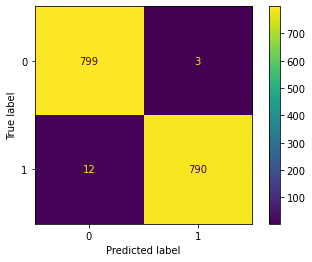

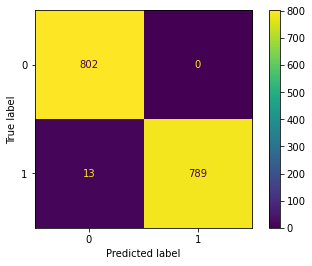

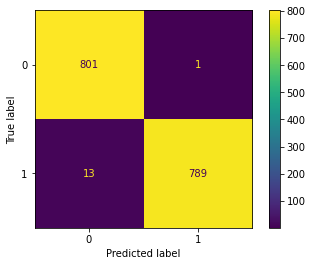

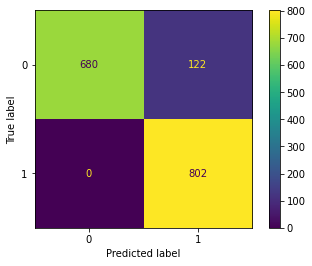

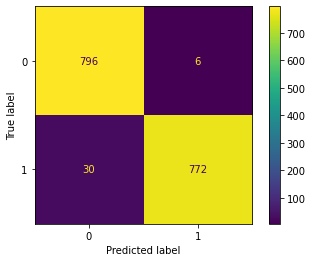

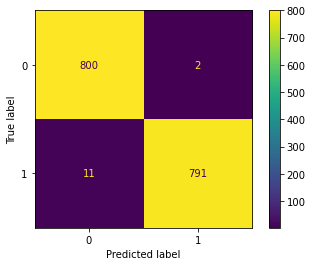

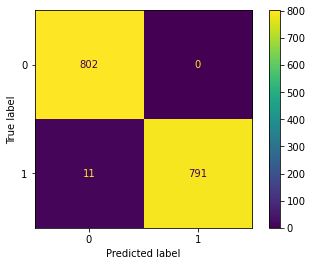

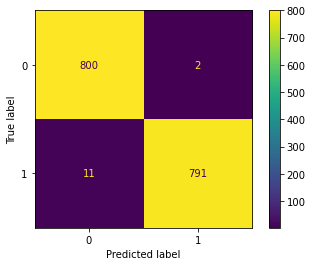

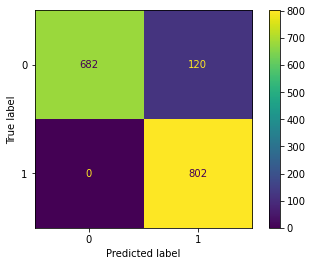

In [69]:
# grid search values
#values = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
values =np.arange(0.1,1,0.1)
all_train, all_test = list(), list()
for param in values:
    #model.add(Dense(500, input_dim=2, activation='relu', kernel_regularizer=l2(param)))
    
    model=Sequential([LSTM(20,return_sequences=True,input_shape=[None,x_ds.shape[2]]),Dropout(param),
           LSTM(10),Dense(1, activation='sigmoid')])
    
    
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    
        # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
    
    
    history=model.fit(X_train, y_train, epochs=1000,batch_size=1024,validation_data=(X_test, y_test),callbacks=[es,mc])
    # evaluate the model
    saved_model = load_model('best_model.h5')
    
    # evaluate the model
    _, train_acc = model.evaluate(X_train, y_train, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print('Param: %f, Train: %.3f, Test: %.3f' % (param, train_acc, test_acc))
    all_train.append(train_acc)
    all_test.append(test_acc)

    scores = model.evaluate(X_test, y_test)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

    y_pred = model.predict_classes(X_test)
    cm=confusion_matrix(y_test, y_pred)

    tn, fp, fn, tp = cm.ravel()

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot() 

    fpr=fp/(fp+tn)
    print(" Fall out is " + str(fpr))

    fnr=fn/(fn+tp)
    print(" Miss rate is " + str(fnr))



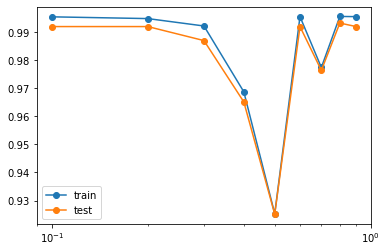

In [48]:
# plot train and test means
pyplot.semilogx(values, all_train, label='train', marker='o')
pyplot.semilogx(values, all_test, label='test', marker='o')
pyplot.legend()
pyplot.show()

# Regularizers

In [108]:
from tensorflow.keras import regularizers

Epoch 1/1000
903/903 [==============================] - ETA: 0s - loss: 0.2816 - accuracy: 0.8859
Epoch 00001: val_accuracy improved from -inf to 0.91895, saving model to best_model1.h5
903/903 [==============================] - 34s 38ms/step - loss: 0.2816 - accuracy: 0.8859 - val_loss: 0.1498 - val_accuracy: 0.9190
Epoch 2/1000
902/903 [============================>.] - ETA: 0s - loss: 0.1545 - accuracy: 0.9174
Epoch 00002: val_accuracy did not improve from 0.91895
903/903 [==============================] - 30s 33ms/step - loss: 0.1545 - accuracy: 0.9174 - val_loss: 0.1301 - val_accuracy: 0.9190
Epoch 3/1000
903/903 [==============================] - ETA: 0s - loss: 0.1376 - accuracy: 0.9176
Epoch 00003: val_accuracy improved from 0.91895 to 0.91958, saving model to best_model1.h5
903/903 [==============================] - 28s 31ms/step - loss: 0.1376 - accuracy: 0.9176 - val_loss: 0.1100 - val_accuracy: 0.9196
Epoch 4/1000
903/903 [==============================] - ETA: 0s - loss: 0

Epoch 29/1000
902/903 [============================>.] - ETA: 0s - loss: 0.0181 - accuracy: 0.9954
Epoch 00029: val_accuracy did not improve from 0.99314
903/903 [==============================] - 24s 26ms/step - loss: 0.0181 - accuracy: 0.9954 - val_loss: 0.0243 - val_accuracy: 0.9931
Epoch 30/1000
902/903 [============================>.] - ETA: 0s - loss: 0.0185 - accuracy: 0.9950
Epoch 00030: val_accuracy did not improve from 0.99314
903/903 [==============================] - 26s 28ms/step - loss: 0.0185 - accuracy: 0.9950 - val_loss: 0.0246 - val_accuracy: 0.9931
Epoch 31/1000
902/903 [============================>.] - ETA: 0s - loss: 0.0181 - accuracy: 0.9955
Epoch 00031: val_accuracy did not improve from 0.99314
903/903 [==============================] - 24s 26ms/step - loss: 0.0181 - accuracy: 0.9955 - val_loss: 0.0239 - val_accuracy: 0.9931
Epoch 32/1000
901/903 [============================>.] - ETA: 0s - loss: 0.0211 - accuracy: 0.9945
Epoch 00032: val_accuracy did not improv

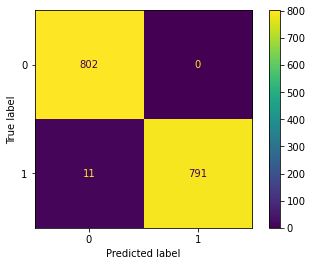

In [118]:
model= Sequential([LSTM(20,return_sequences=True,input_shape=[None,x_ds.shape[2]]), Dropout(0.2),
           LSTM(10),Dropout(0.2),Dense(1, activation='sigmoid')])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# Fit the model


# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('best_model1.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)


history=model.fit(X_train, y_train, epochs=1000,batch_size=16,validation_data=(X_test, y_test),callbacks=[es,mc])
# evaluate the model
#saved_model = load_model('best_model.h5')

scores = model.evaluate(X_test, y_test)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

y_pred = model.predict_classes(X_test)
cm=confusion_matrix(y_test, y_pred)

tn, fp, fn, tp = cm.ravel()

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot() 

fpr=fp/(fp+tn)
print(" Fall out is " + str(fpr))

fnr=fn/(fn+tp)
print(" Miss rate is " + str(fnr))

In [119]:
print(model.summary())

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_45 (LSTM)               (None, None, 20)          12400     
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 20)          0         
_________________________________________________________________
lstm_46 (LSTM)               (None, 10)                1240      
_________________________________________________________________
dropout_3 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 11        
Total params: 13,651
Trainable params: 13,651
Non-trainable params: 0
_________________________________________________________________
None


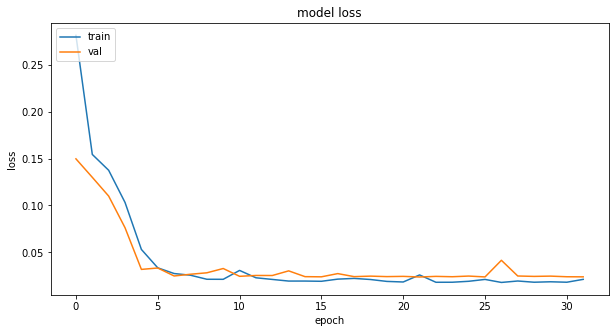

In [120]:
from matplotlib import pyplot as plt
history.history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

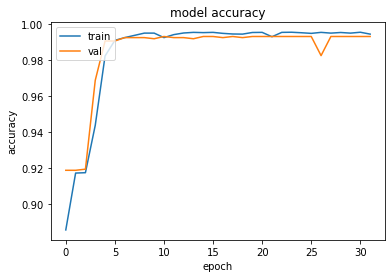

In [121]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

Epoch 1/1000
225/226 [============================>.] - ETA: 0s - loss: 0.7656 - accuracy: 0.8311 ETA: 1s
Epoch 00001: val_accuracy improved from -inf to 0.91895, saving model to best_model2.h5
226/226 [==============================] - 13s 58ms/step - loss: 0.7646 - accuracy: 0.8313 - val_loss: 0.3105 - val_accuracy: 0.9190
Epoch 2/1000
226/226 [==============================] - ETA: 0s - loss: 0.2597 - accuracy: 0.9157
Epoch 00002: val_accuracy improved from 0.91895 to 0.91958, saving model to best_model2.h5
226/226 [==============================] - 9s 41ms/step - loss: 0.2597 - accuracy: 0.9157 - val_loss: 0.2241 - val_accuracy: 0.9196
Epoch 3/1000
225/226 [============================>.] - ETA: 0s - loss: 0.2508 - accuracy: 0.9076 ETA: 0s - loss: 0.2537 - accu
Epoch 00003: val_accuracy did not improve from 0.91958
226/226 [==============================] - 9s 39ms/step - loss: 0.2511 - accuracy: 0.9073 - val_loss: 0.1964 - val_accuracy: 0.9190
Epoch 4/1000
225/226 [===============

225/226 [============================>.] - ETA: 0s - loss: 0.0650 - accuracy: 0.9846
Epoch 00055: val_accuracy did not improve from 0.99314
226/226 [==============================] - 10s 45ms/step - loss: 0.0650 - accuracy: 0.9846 - val_loss: 0.0921 - val_accuracy: 0.9707
Epoch 56/1000
226/226 [==============================] - ETA: 0s - loss: 0.0623 - accuracy: 0.9858
Epoch 00056: val_accuracy did not improve from 0.99314
226/226 [==============================] - 10s 45ms/step - loss: 0.0623 - accuracy: 0.9858 - val_loss: 0.0584 - val_accuracy: 0.9894
Epoch 57/1000
225/226 [============================>.] - ETA: 0s - loss: 0.0470 - accuracy: 0.9917
Epoch 00057: val_accuracy did not improve from 0.99314
226/226 [==============================] - 11s 49ms/step - loss: 0.0470 - accuracy: 0.9918 - val_loss: 0.0485 - val_accuracy: 0.9925
Epoch 58/1000
226/226 [==============================] - ETA: 0s - loss: 0.0463 - accuracy: 0.9911
Epoch 00058: val_accuracy did not improve from 0.99314

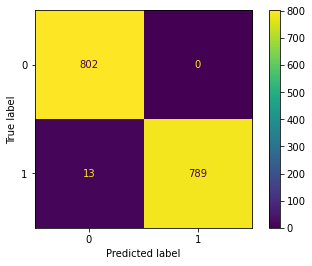

In [131]:
model= Sequential([LSTM(20,return_sequences=True,input_shape=[None,x_ds.shape[2]],kernel_regularizer='l2'),
           LSTM(10,kernel_regularizer='l2'),Dense(1, activation='sigmoid')])


model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# Fit the model


# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('best_model2.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)


history=model.fit(X_train, y_train, epochs=1000,batch_size=64,validation_data=(X_test, y_test),callbacks=[es,mc])
# evaluate the model
saved_model = load_model('best_model2.h5')

scores = model.evaluate(X_test, y_test)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

y_pred = model.predict_classes(X_test)
cm=confusion_matrix(y_test, y_pred)

tn, fp, fn, tp = cm.ravel()

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot() 

fpr=fp/(fp+tn)
print(" Fall out is " + str(fpr))

fnr=fn/(fn+tp)
print(" Miss rate is " + str(fnr))

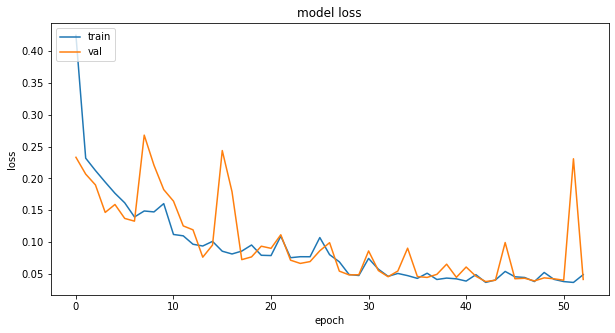

In [127]:
from matplotlib import pyplot as plt
history.history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

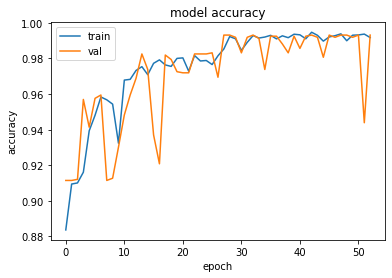

In [128]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [129]:
print(model.summary())

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_50 (LSTM)               (None, None, 20)          12400     
_________________________________________________________________
lstm_51 (LSTM)               (None, 10)                1240      
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 11        
Total params: 13,651
Trainable params: 13,651
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/10
401/401 [==============================] - 37s 93ms/step - loss: 0.3425 - accuracy: 0.8770
Epoch 2/10
401/401 [==============================] - 27s 67ms/step - loss: 0.2095 - accuracy: 0.9144
Epoch 3/10
401/401 [==============================] - 26s 64ms/step - loss: 0.1844 - accuracy: 0.9201
Epoch 4/10
401/401 [==============================] - 25s 63ms/step - loss: 0.1789 - accuracy: 0.9299
Epoch 5/10
401/401 [==============================] - 25s 62ms/step - loss: 0.2895 - accuracy: 0.9124
Epoch 6/10
401/401 [==============================] - 25s 61ms/step - loss: 0.1820 - accuracy: 0.92230s - loss: 0
Epoch 7/10
401/401 [==============================] - ETA: 0s - loss: 0.2117 - accuracy: 0.91 - 24s 60ms/step - loss: 0.2117 - accuracy: 0.9110
Epoch 8/10
401/401 [==============================] - 23s 57ms/step - loss: 0.1996 - accuracy: 0.9160
Epoch 9/10
401/401 [==============================] - 21s 53ms/step - loss: 0.1937 - accuracy: 0.9227
Epoch 10/10
101/101 [=======

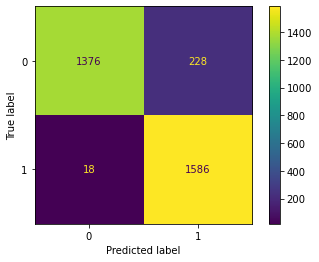

In [138]:
model= Sequential([LSTM(20,return_sequences=True,input_shape=[None,x_ds.shape[2]]), 


            LSTM(20,return_sequences=True,kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
bias_regularizer=regularizers.l2(1e-4),
activity_regularizer=regularizers.l2(1e-5)),
                               LSTM(20,return_sequences=True), LSTM(10),Dense(1)])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# Fit the model
history=model.fit(X_train, y_train, epochs=10)
# evaluate the model
scores = model.evaluate(X_test, y_test)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

y_pred = model.predict_classes(X_test)
cm=confusion_matrix(y_test, y_pred)

tn, fp, fn, tp = cm.ravel()

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot() 

fpr=fp/(fp+tn)
print(" Fall out is " + str(fpr))

fnr=fn/(fn+tp)
print(" Miss rate is " + str(fnr))

Epoch 1/10
401/401 [==============================] - 26s 65ms/step - loss: 0.5533 - accuracy: 0.7814
Epoch 2/10
401/401 [==============================] - 26s 64ms/step - loss: 0.2864 - accuracy: 0.8687
Epoch 3/10
401/401 [==============================] - 25s 63ms/step - loss: 0.1888 - accuracy: 0.9140
Epoch 4/10
401/401 [==============================] - 23s 56ms/step - loss: 0.2653 - accuracy: 0.9061
Epoch 5/10
401/401 [==============================] - 23s 58ms/step - loss: 0.1715 - accuracy: 0.9211
Epoch 6/10
401/401 [==============================] - 23s 58ms/step - loss: 0.1394 - accuracy: 0.9470
Epoch 7/10
401/401 [==============================] - 23s 58ms/step - loss: 0.2255 - accuracy: 0.9115
Epoch 8/10
401/401 [==============================] - 23s 58ms/step - loss: 0.1675 - accuracy: 0.91941s -
Epoch 9/10
401/401 [==============================] - 23s 57ms/step - loss: 0.2124 - accuracy: 0.8894
Epoch 10/10
101/101 [==============================] - 1s 15ms/step - loss: 0.

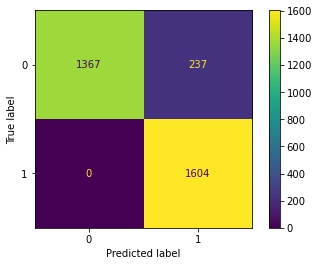

In [139]:
model= Sequential([LSTM(20,return_sequences=True,input_shape=[None,x_ds.shape[2]]), 


            LSTM(20,return_sequences=True,kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
bias_regularizer=regularizers.l2(1e-4),
activity_regularizer=regularizers.l2(1e-5)),
                               LSTM(20,return_sequences=True), LSTM(10,kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),Dense(1,kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# Fit the model
history=model.fit(X_train, y_train, epochs=10)
# evaluate the model
scores = model.evaluate(X_test, y_test)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

y_pred = model.predict_classes(X_test)
cm=confusion_matrix(y_test, y_pred)

tn, fp, fn, tp = cm.ravel()

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot() 

fpr=fp/(fp+tn)
print(" Fall out is " + str(fpr))

fnr=fn/(fn+tp)
print(" Miss rate is " + str(fnr))

In [ ]:
kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
bias_regularizer=regularizers.l2(1e-4),
activity_regularizer=regularizers.l2(1e-5)

# Balance Test and Training Set

In [43]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=120)
sss.get_n_splits(x_ds, y_ds)

for train_idx, test_idx in sss.split(x_ds, y_ds):
    print("TRAIN:", train_idx, "TEST:", test_idx)
    X_train, X_test=x_ds[train_idx], x_ds[test_idx]
    y_train, y_test=y_ds[train_idx], y_ds[test_idx]
    
    
    
    
def sequences(x_ds,y_ds):


    c_normal=[]
    c_abnormal=[]
    for i in range(len(x_ds)):

        count_normal=0
        count_abnormal=0

        if(y_ds[i]==1):
            for j in x_ds[i]:
                if(sum(j)!= 0):
                        count_abnormal+=1
            c_abnormal.append(count_abnormal)



        if(y_ds[i]==0):
            for j in x_ds[i]:
                if(sum(j)!= 0):
                        count_normal+=1
            c_normal.append(count_normal)



    set(c_normal)
    set(c_abnormal)



    pd.Series(c_normal).value_counts()
    pd.Series(c_abnormal).value_counts()
    
    
    return c_normal,c_abnormal


    
y_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

c_normal,c_abnormal=sequences(X_train,y_train)
c_normal,c_abnormal=sequences(X_test,y_test)


pd.Series(c_normal).value_counts()
pd.Series(c_abnormal).value_counts()

data_visualize(X_test,y_test)
data_visualize(X_train,y_train)

TRAIN: [ 1592 15431  1734 ...  2306  5703 12020] TEST: [ 3320 11496  1604 ... 14127 10585  6610]


Sequence Analysis 
Number of sequences is 1604
Number of abnormal sequences is 802
Number of features is 134
Percentage of abnormal sequences is 50.0



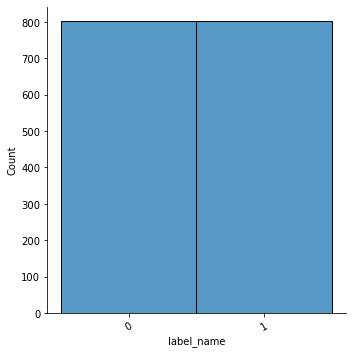

Sequence Analysis 
Number of sequences is 14434
Number of abnormal sequences is 7217
Number of features is 134
Percentage of abnormal sequences is 50.0



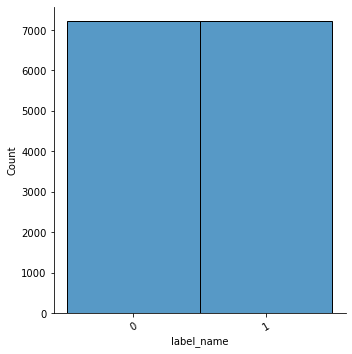

In [50]:
def sequences(x_ds,y_ds):


    c_normal=[]
    c_abnormal=[]
    for i in range(len(x_ds)):

        count_normal=0
        count_abnormal=0

        if(y_ds[i]==1):
            for j in x_ds[i]:
                if(sum(j)!= 0):
                        count_abnormal+=1
            c_abnormal.append(count_abnormal)



        if(y_ds[i]==0):
            for j in x_ds[i]:
                if(sum(j)!= 0):
                        count_normal+=1
            c_normal.append(count_normal)



    set(c_normal)
    set(c_abnormal)



    pd.Series(c_normal).value_counts()
    pd.Series(c_abnormal).value_counts()
    
    
    return c_normal,c_abnormal

In [51]:
c_normal,c_abnormal=sequences(X_train,y_train)

In [52]:
pd.Series(c_normal).value_counts()

1     3903
2     2147
4      800
6      199
3       76
8       67
10      17
5        4
12       2
14       1
20       1
dtype: int64

In [53]:
pd.Series(c_abnormal).value_counts()

2     3217
3     1815
5      703
4      656
6      225
8      166
7      159
10     102
12      82
14      61
20      31
dtype: int64

In [105]:
from matplotlib import pyplot as plt

In [114]:
from matplotlib import pyplot as plt
history.history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

{'loss': [0.3613350987434387,
  0.19898945093154907,
  0.04701767861843109,
  0.21722464263439178,
  0.26127007603645325],
 'accuracy': [0.8386530876159668,
  0.9665614366531372,
  0.9863206148147583,
  0.9179235100746155,
  0.9700689911842346],
 'val_loss': [2.4328815937042236,
  12.135852813720703,
  13.765564918518066,
  4.52092981338501,
  15.424939155578613],
 'val_accuracy': [0.021972885355353355,
  0.06451612710952759,
  0.07713884860277176,
  0.0,
  0.0]}

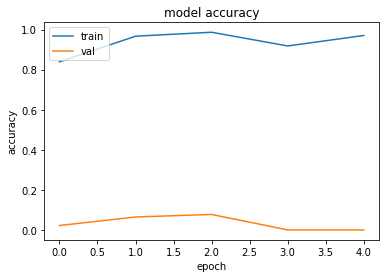

In [115]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

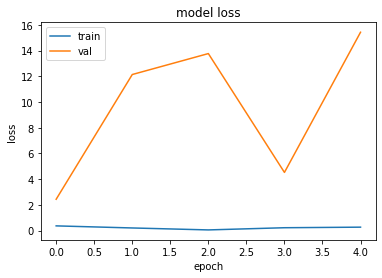

In [116]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [ ]:
# Roc Curve

    rnn_fpr, rnn_tpr, _ = roc_curve(y_ds[test], y_pred)
    pyplot.plot(rnn_fpr, rnn_tpr, marker='.', label='LSTM')
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()
    
    
    from sklearn.metrics import roc_auc_score
    rnn_auc = roc_auc_score(y_ds[test], y_pred)
    print("The area under curve is " + str(rnn_auc))
    
    
    from sklearn.metrics import precision_recall_curve
    from sklearn.metrics import f1_score
    from sklearn.metrics import auc

    rnn_precision, rnn_recall, _ = precision_recall_curve(y_ds[test], y_pred)
    rnn_f1, rnn_auc = f1_score(y_ds[test], y_pred), auc(rnn_recall, rnn_precision)
    # summarize scores
    print('RNN: f1=%.3f auc=%.3f' % (rnn_f1, rnn_auc))
    # plot the precision-recall curves
    pyplot.plot(rnn_recall, rnn_precision, marker='.', label='RNN')
    # axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

In [125]:
print(model.summary())

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_132 (LSTM)              (None, None, 20)          12400     
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 20)          0         
_________________________________________________________________
lstm_133 (LSTM)              (None, None, 20)          3280      
_________________________________________________________________
lstm_134 (LSTM)              (None, None, 20)          3280      
_________________________________________________________________
lstm_135 (LSTM)              (None, 10)                1240      
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 11        
Total params: 20,211
Trainable params: 20,211
Non-trainable params: 0
_________________________________________________

In [102]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

NameError: name 'plot_model' is not defined

# Results Analysis

In this section we will analyze our results.

## Confusion Matrix